In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import roc_curve, auc, accuracy_score
from tensorflow.keras.layers import *
from tensorflow.keras import models, Model
import qkeras
from qkeras import *
from sparsepixels.layers import *
from sparsepixels.utils import *

#### ---> extract raw images and necessary info from official samples
#run_batch(which="inclusive", overwrite_outputs=True, store_all=True)
#run_batch(which="nue", overwrite_outputs=True, store_all=True)

#### ---> slim files with filtering by min signal hits
#incl_in = [f"datasets/neutrino/data_inclusive_plane{p}.h5" for p in (0,1,2)]
#incl_out = [f"datasets/neutrino/data_inclusive_plane{p}_slim_500.h5" for p in (0,1,2)]
#nue_in = [f"datasets/neutrino/data_nue_plane{p}.h5" for p in (0,1,2)]
#nue_out = [f"datasets/neutrino/data_nue_plane{p}_slim_500.h5" for p in (0,1,2)]
#for inp, outp in zip(incl_in, incl_out):
    #write_slim_plane_ge_threshold(inp, outp, threshold=500, overwrite=True, verbose=True)
#for inp, outp in zip(nue_in, nue_out):
    #write_slim_plane_ge_threshold(inp, outp, threshold=500, overwrite=True, verbose=True)

#### ---> extract sig/bkg windows into training-ready files
#write_patches_from_slim_file("datasets/neutrino/data_inclusive_plane2_slim_500.h5", win_t=256, win_w=512, num_bkg=5)
#write_patches_from_slim_file("datasets/neutrino/data_inclusive_plane0_slim_500.h5", win_t=256, win_w=512, num_bkg=5)
#write_patches_from_slim_file("datasets/neutrino/data_inclusive_plane1_slim_500.h5", win_t=256, win_w=512, num_bkg=5)
#write_patches_from_slim_file("datasets/neutrino/data_nue_plane0_slim_500.h5", win_t=256, win_w=512, num_bkg=5)
#write_patches_from_slim_file("datasets/neutrino/data_nue_plane1_slim_500.h5", win_t=256, win_w=512, num_bkg=5)
#write_patches_from_slim_file("datasets/neutrino/data_nue_plane2_slim_500.h5", win_t=256, win_w=512, num_bkg=5)

[data_inclusive_plane2_slim_500.h5] idx=0 eid=(7004, 331, 16552) total_sig=1638, in_win=1239 (75.6%), bkg_found=5


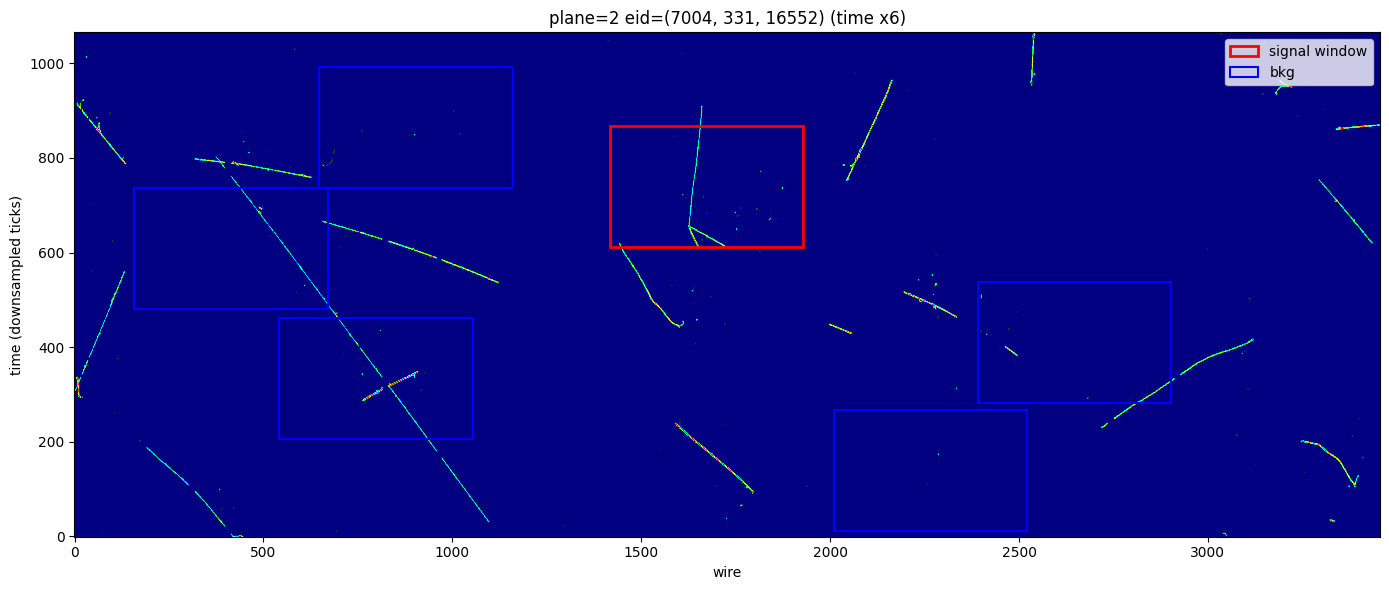

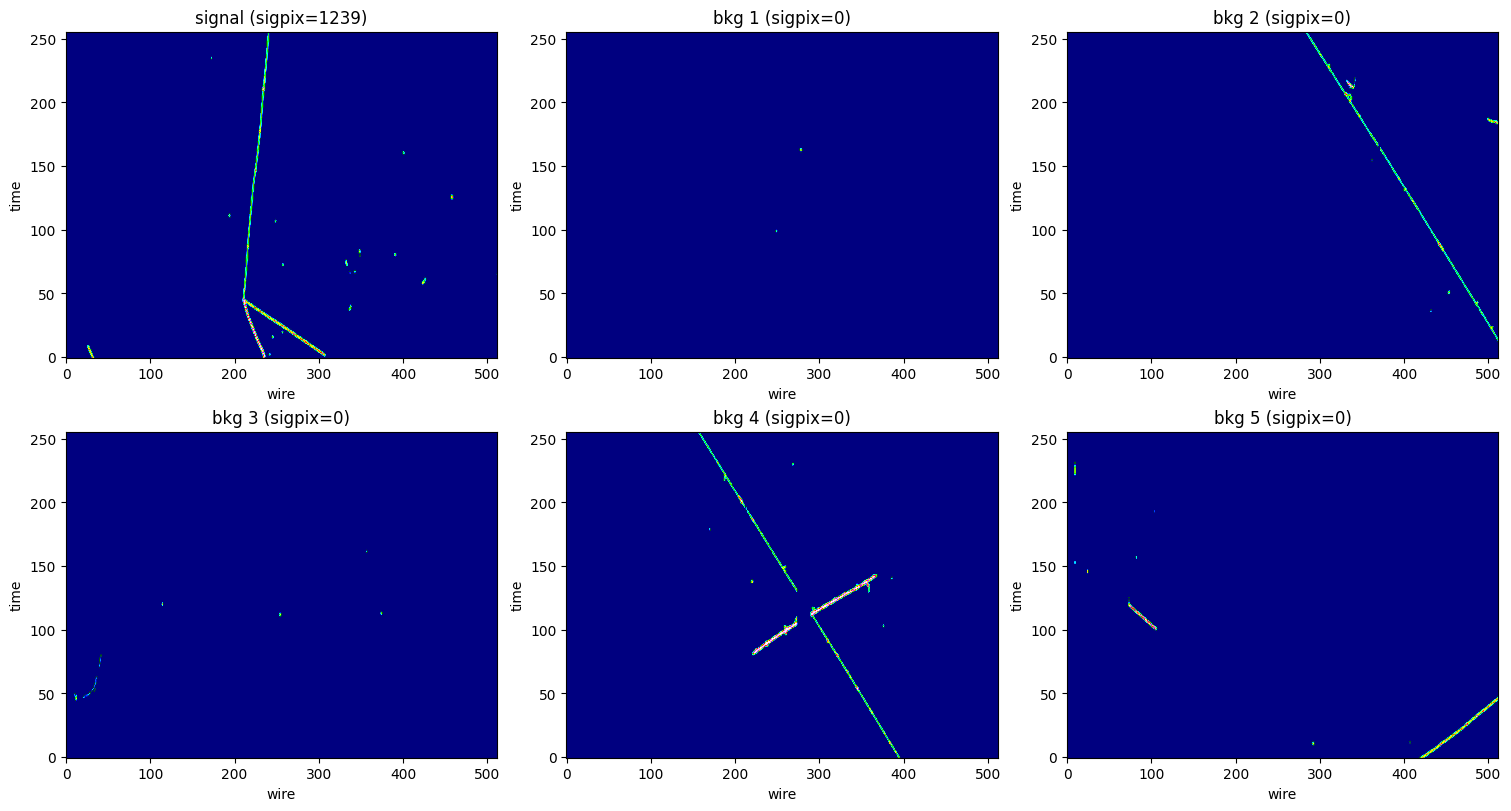

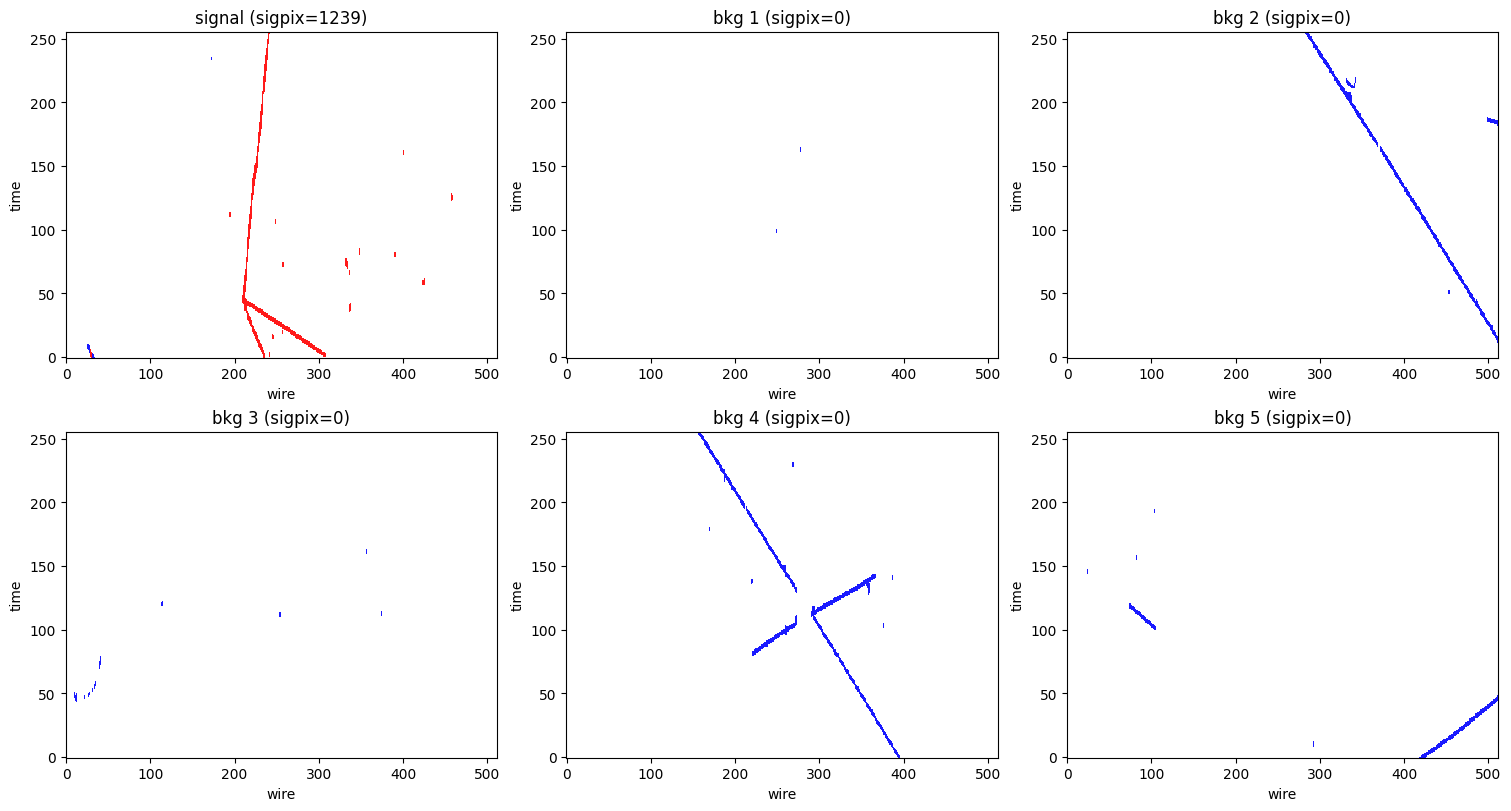

[data_inclusive_plane2_slim_500.h5] idx=1 eid=(7004, 331, 16561) total_sig=2108, in_win=1225 (58.1%), bkg_found=5


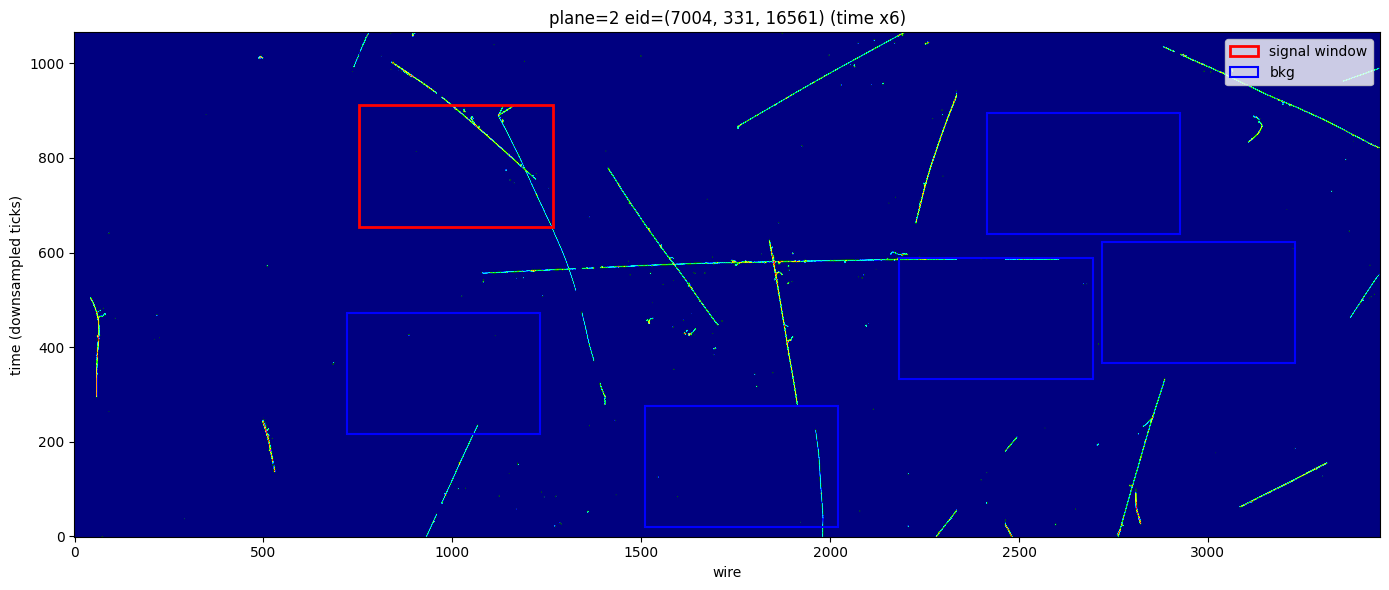

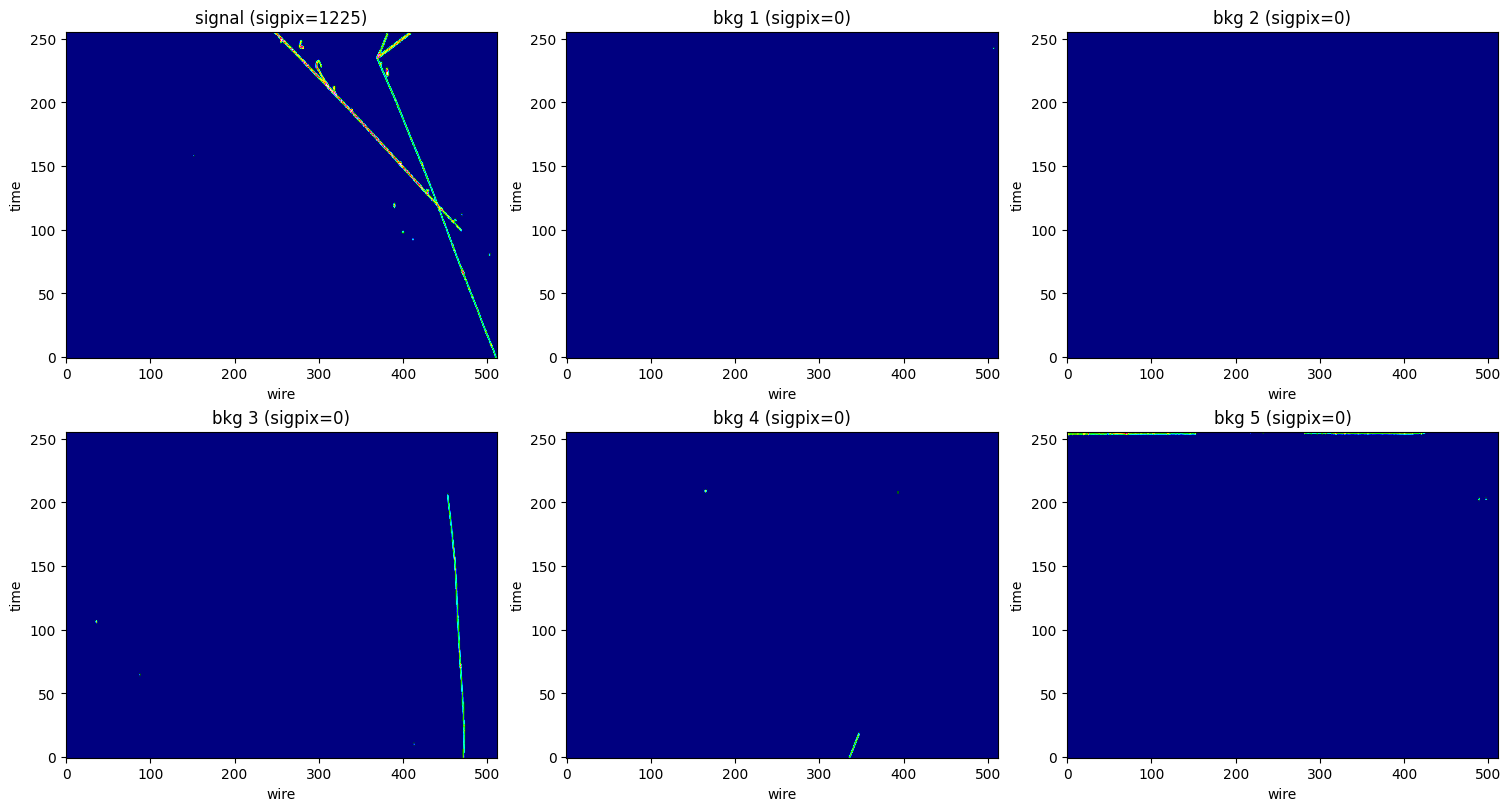

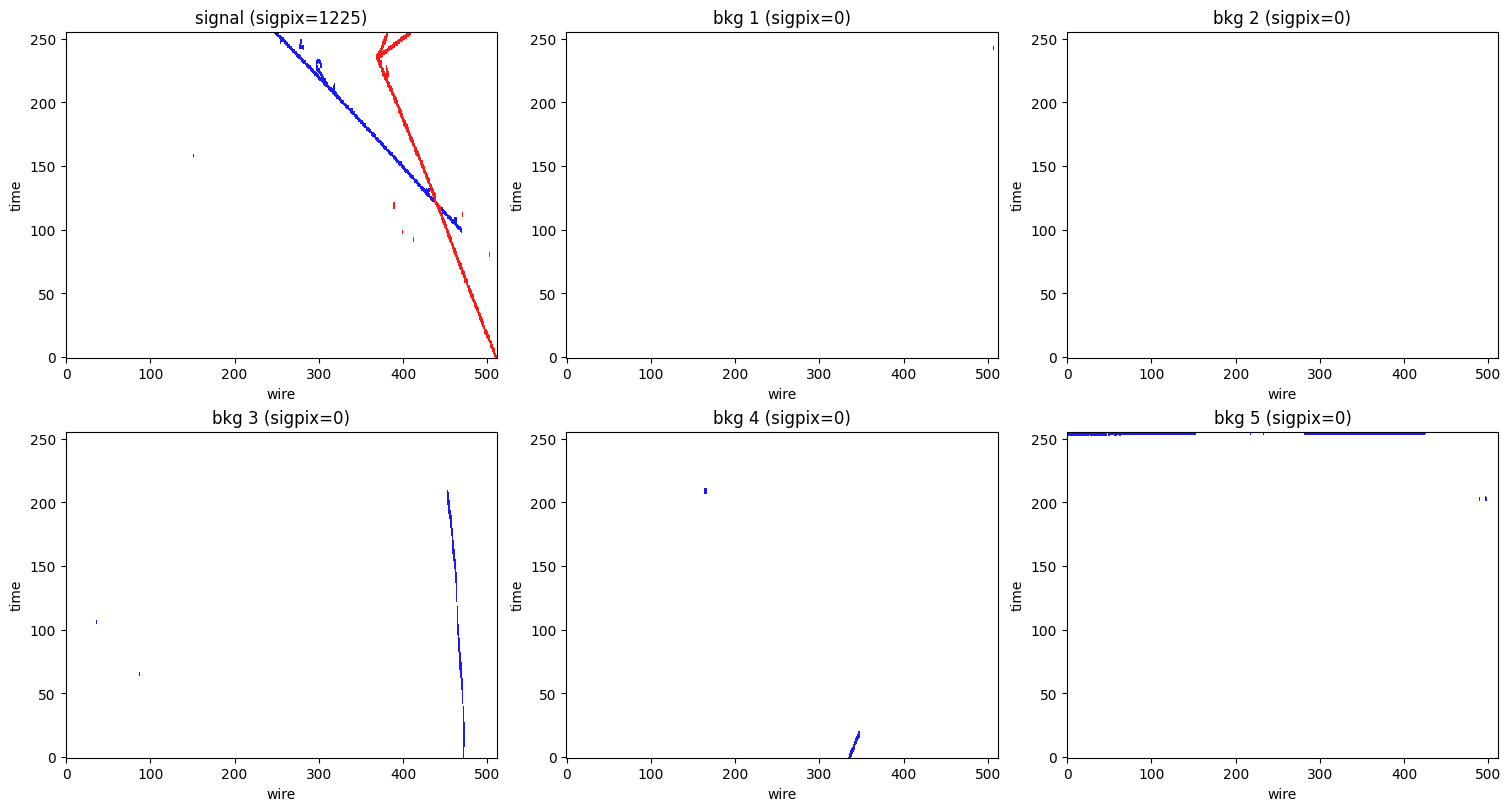

[data_inclusive_plane2_slim_500.h5] idx=2 eid=(7004, 331, 16564) total_sig=1228, in_win=1175 (95.7%), bkg_found=5


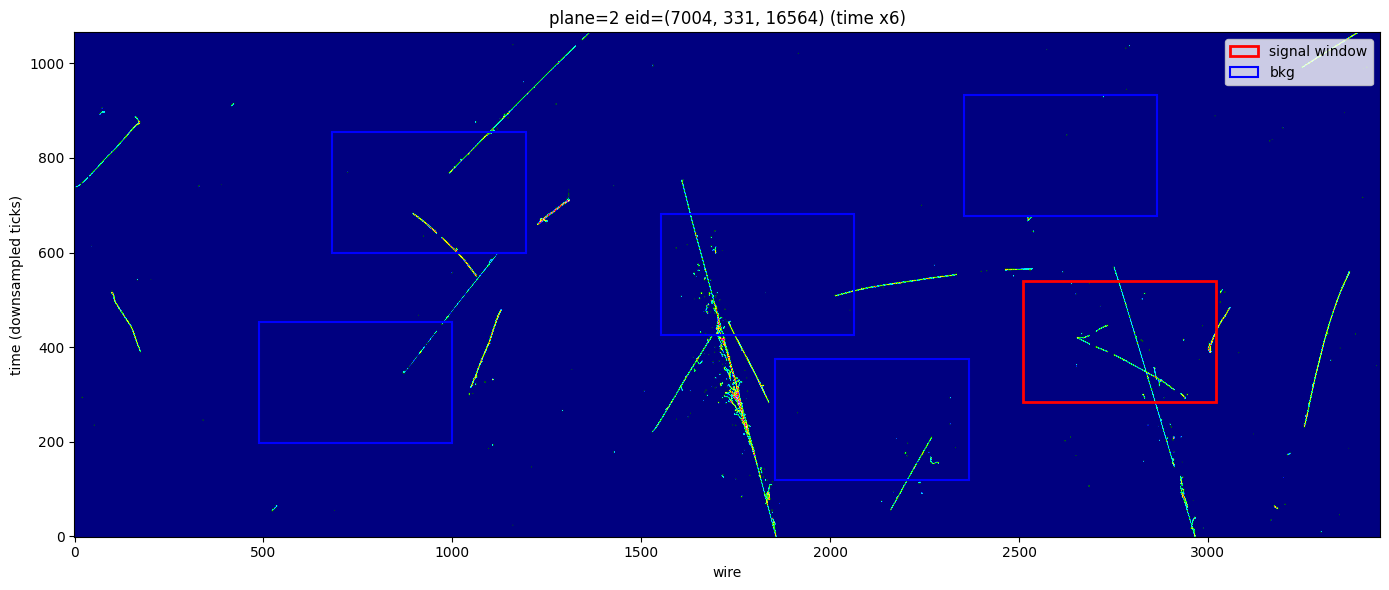

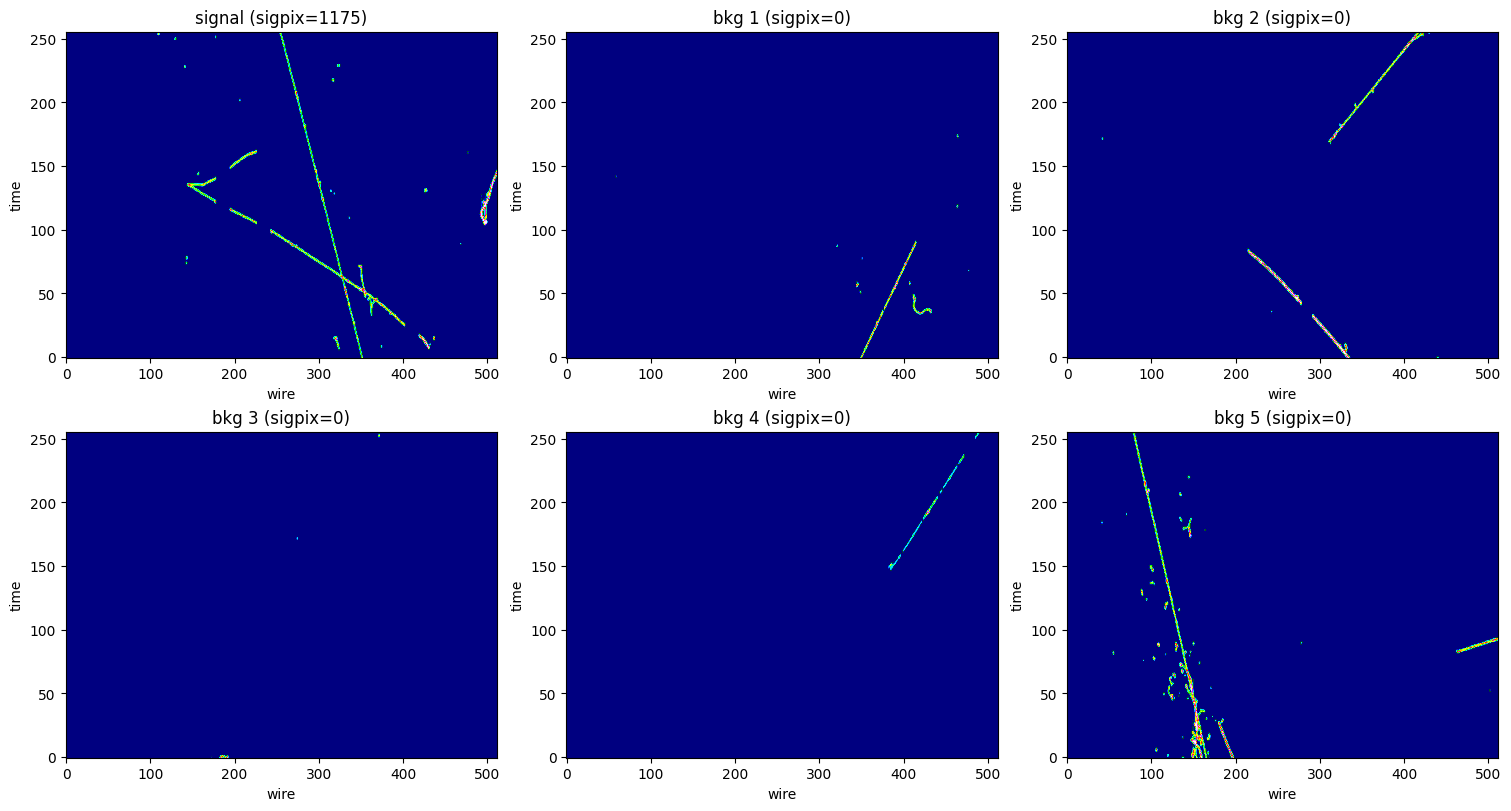

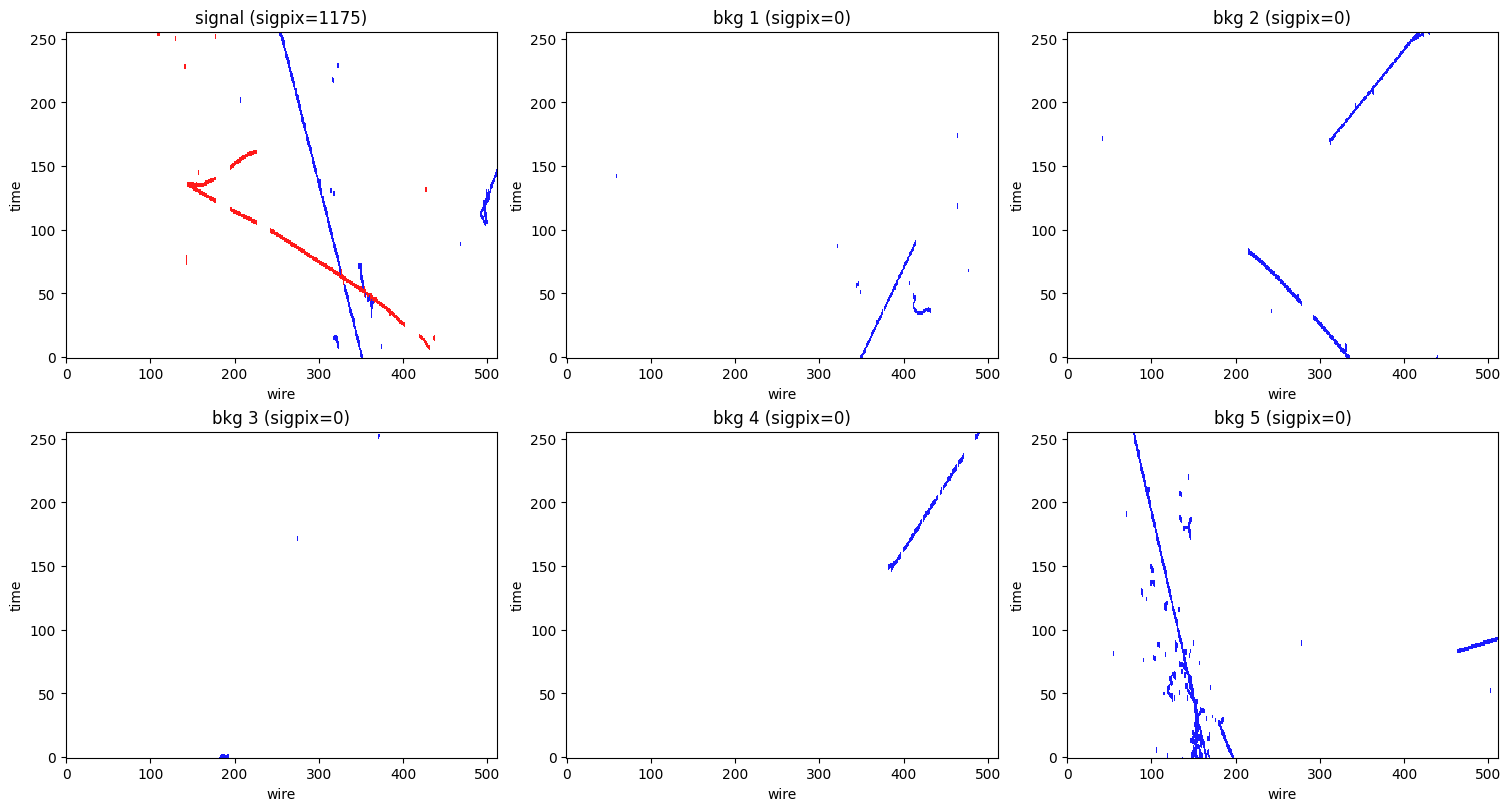

[data_inclusive_plane2_slim_500.h5] idx=3 eid=(7004, 331, 16566) total_sig=2312, in_win=1986 (85.9%), bkg_found=5


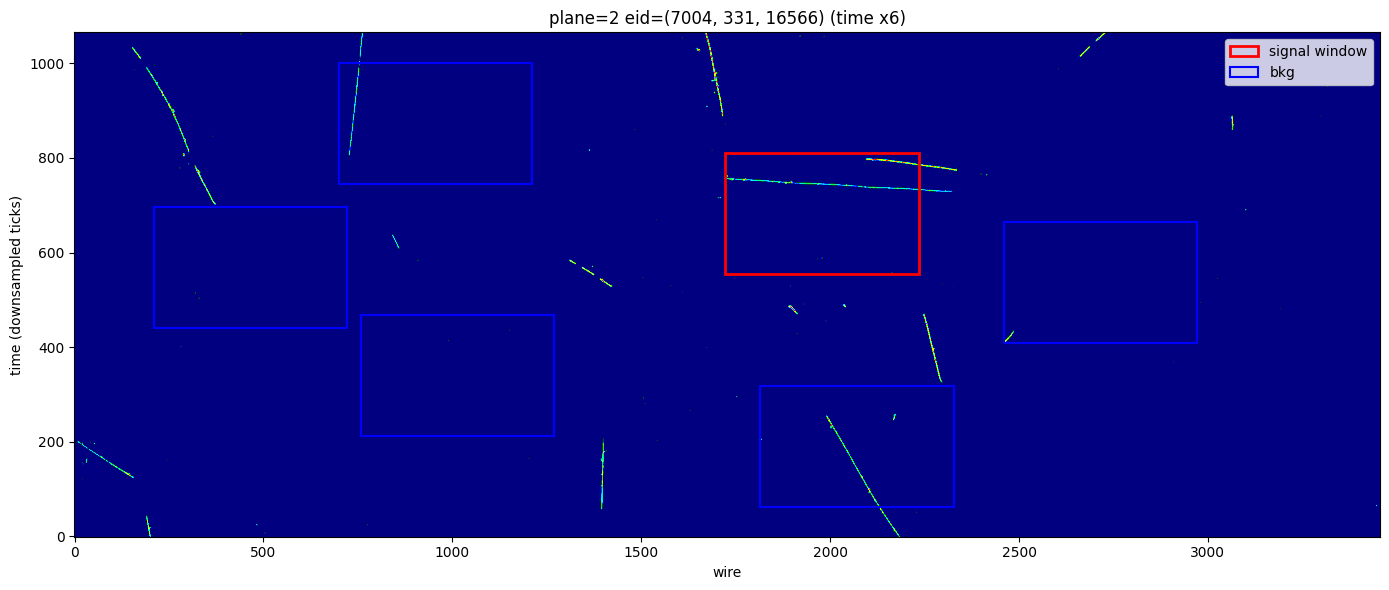

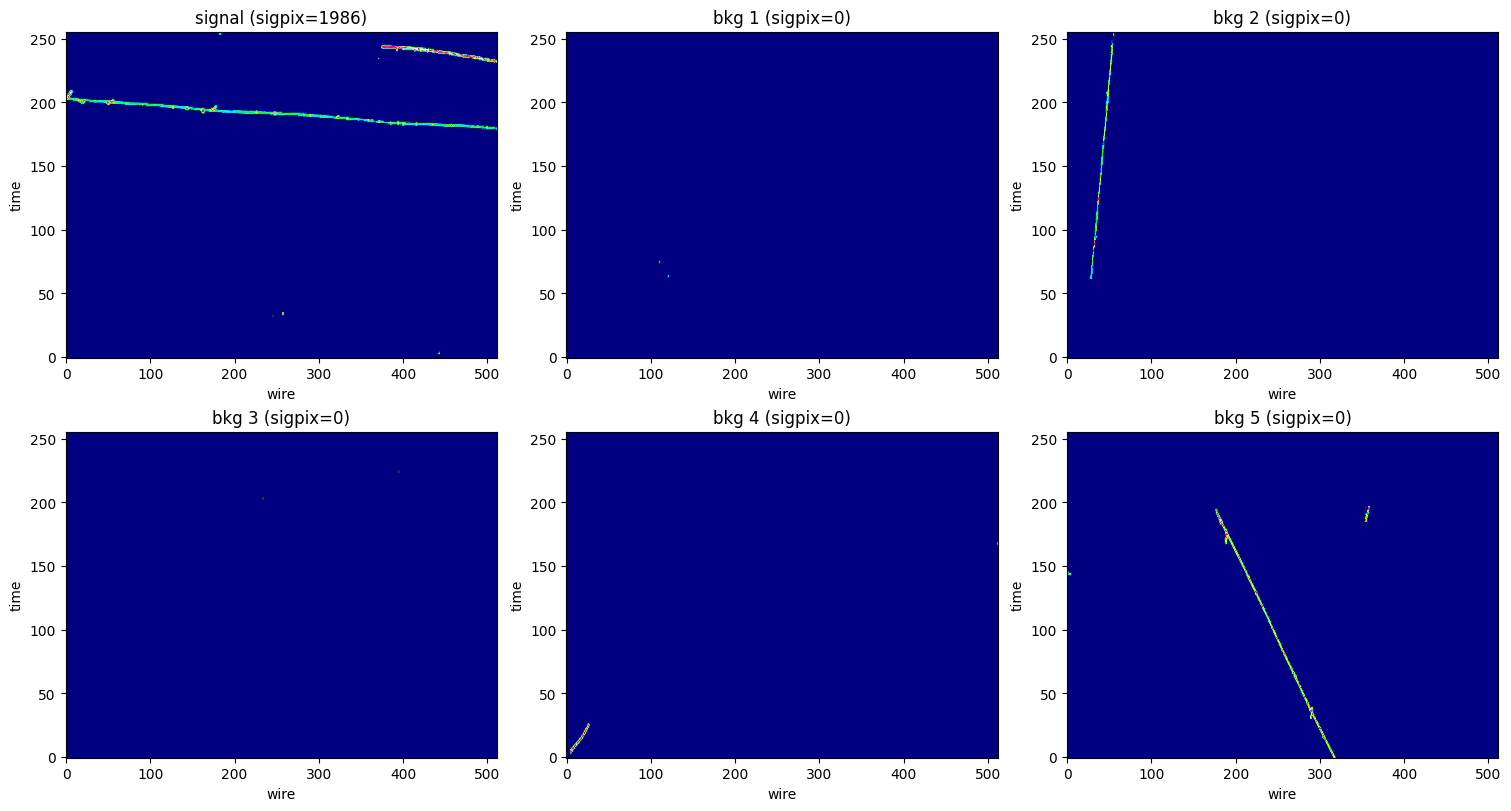

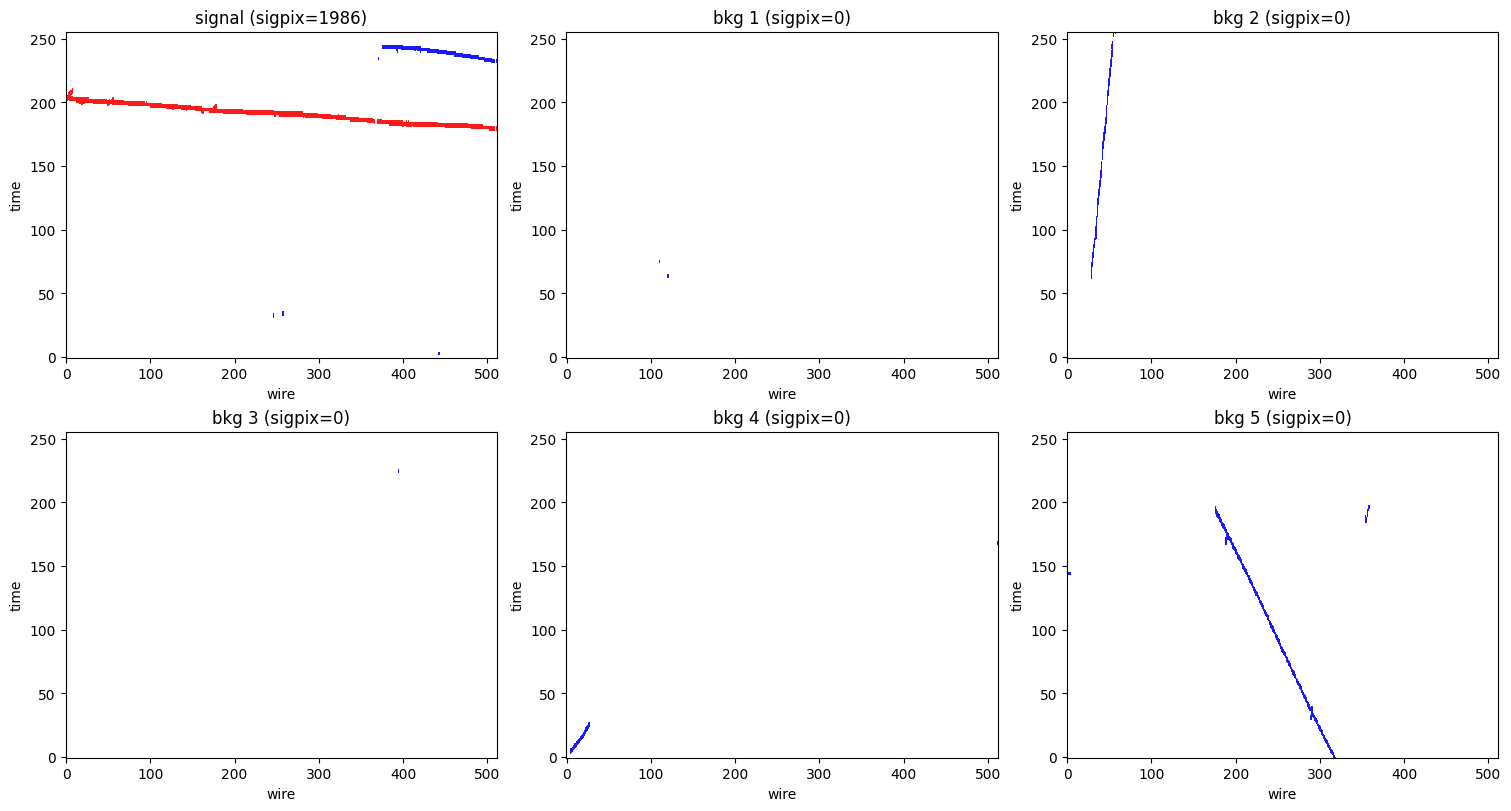

[data_inclusive_plane2_slim_500.h5] idx=4 eid=(7004, 331, 16567) total_sig=10117, in_win=1882 (18.6%), bkg_found=5


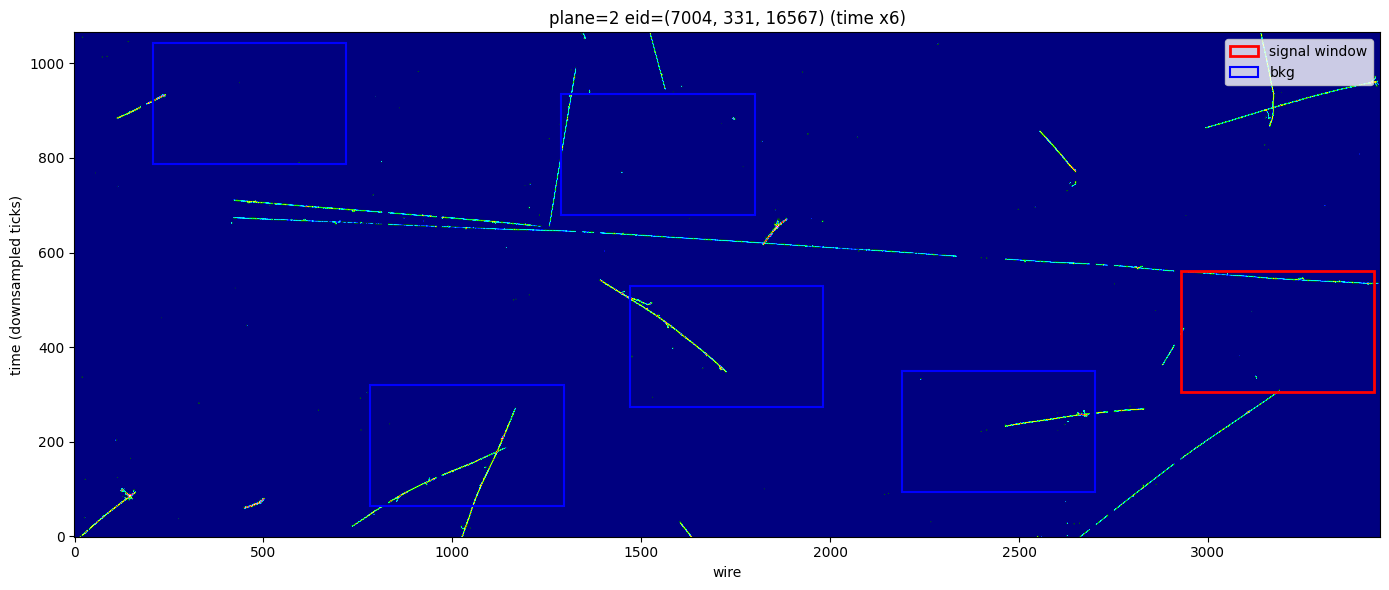

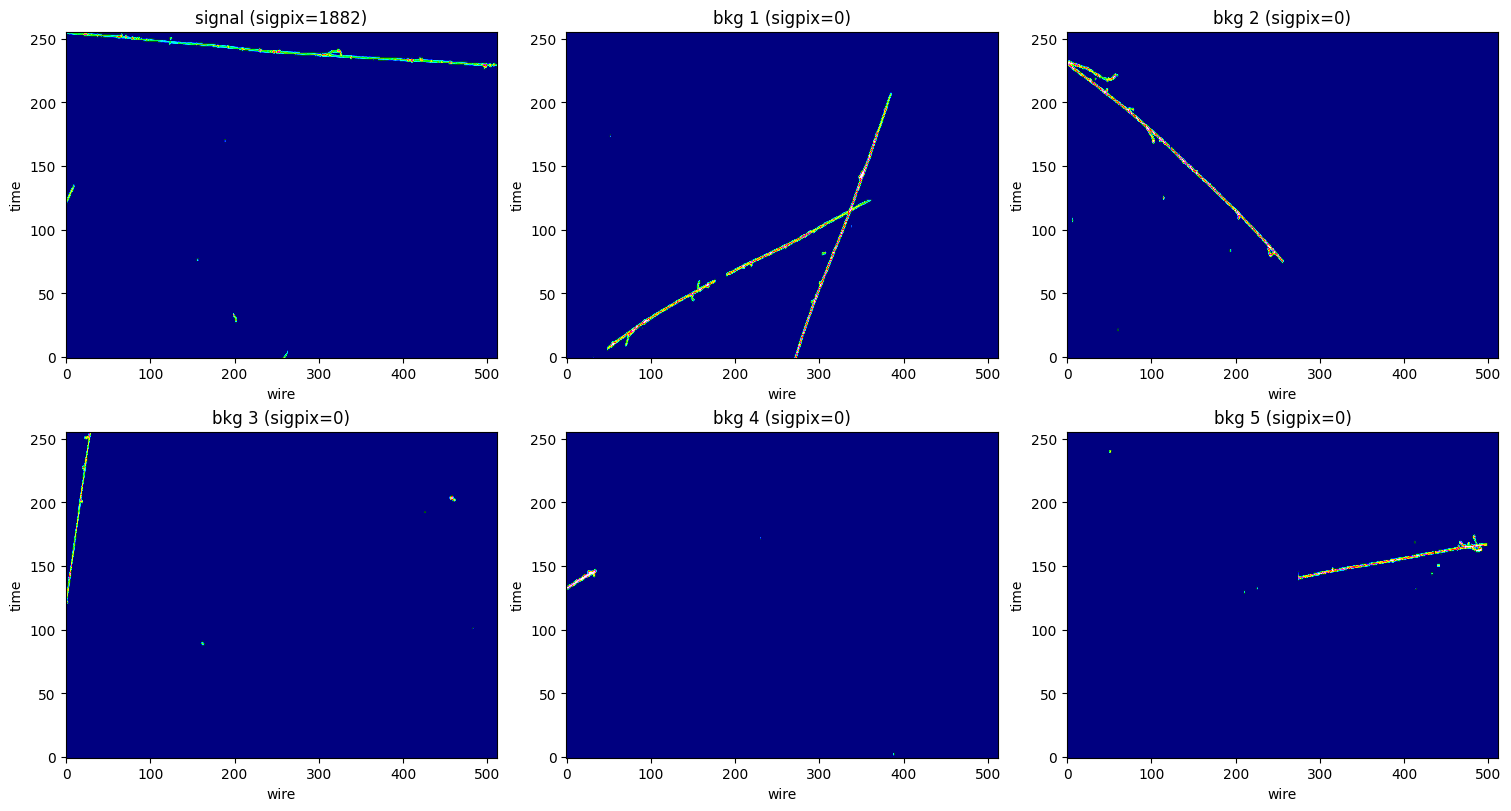

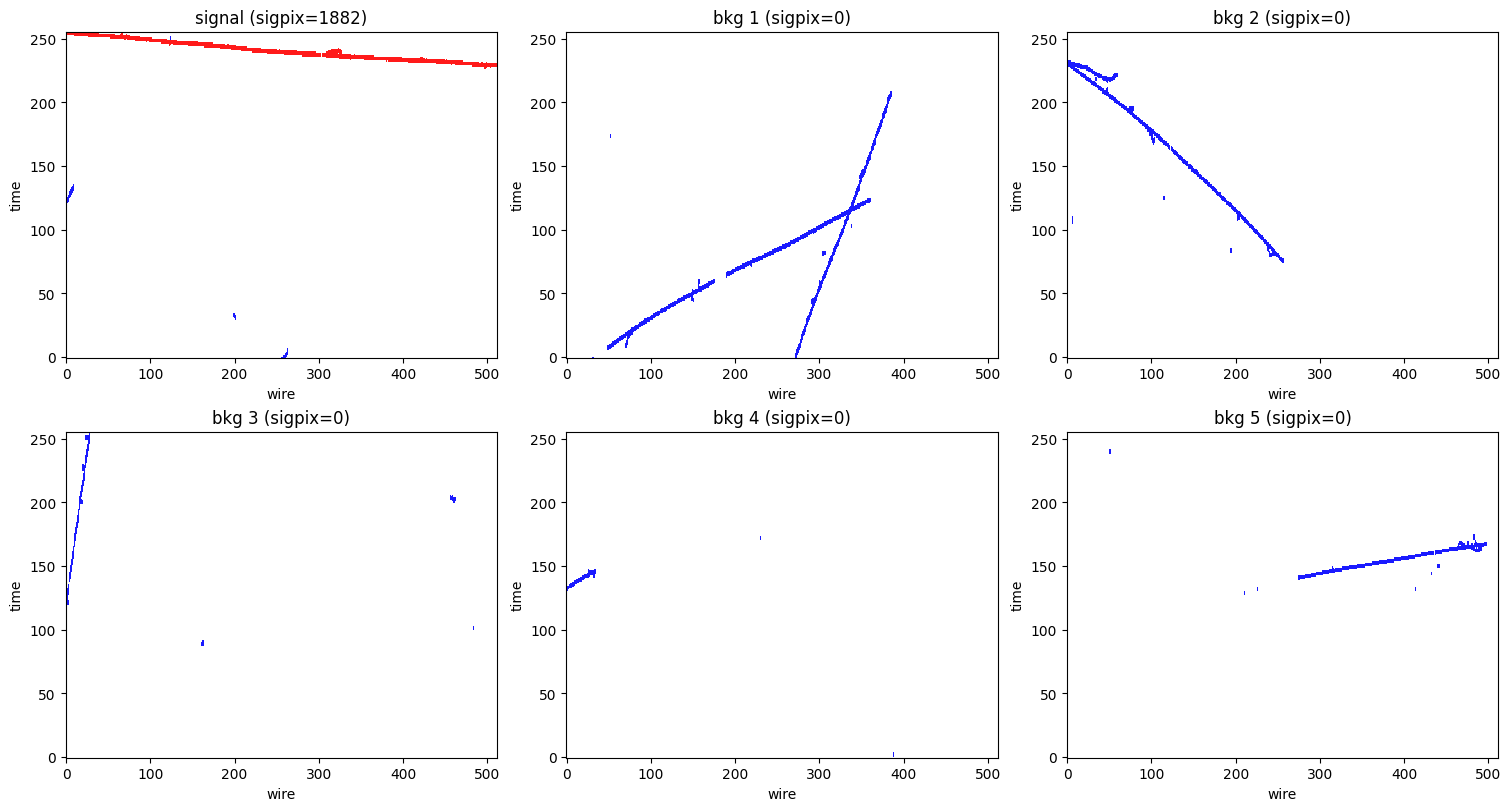

In [2]:
#plot_plane_sample("datasets/neutrino/data_inclusive_plane2_slim_500.h5", idx=0, p='raw',   jet_vmin=0, jet_vmax=100, cmap='gist_ncar')
#plot_plane_sample("datasets/neutrino/data_inclusive_plane2_slim_500.h5", idx=0, p='sig', point_size=3)
#plot_plane_sample("datasets/neutrino/data_inclusive_plane2_slim_500.h5", idx=0, p='bkg', point_size=3)
#plot_plane_sample("datasets/neutrino/data_inclusive_plane2_slim_500.h5", idx=0, p='sigbkg', point_size=3)

run_window_demo("datasets/neutrino/data_inclusive_plane2_slim_500.h5", first_N=5, win_t=256, win_w=512, num_bkg=5, cmap='gist_ncar', vmin=0, vmax=100)
#run_window_demo("datasets/neutrino/data_nue_plane2_slim_500.h5", first_N=5, win_t=256, win_w=512, num_bkg=5, cmap='gist_ncar', vmin=0, vmax=100)

sig_in_window / sig_in_evt = 1239 / 1638 | bkg_in_window = 31 | total_in_window = 1270


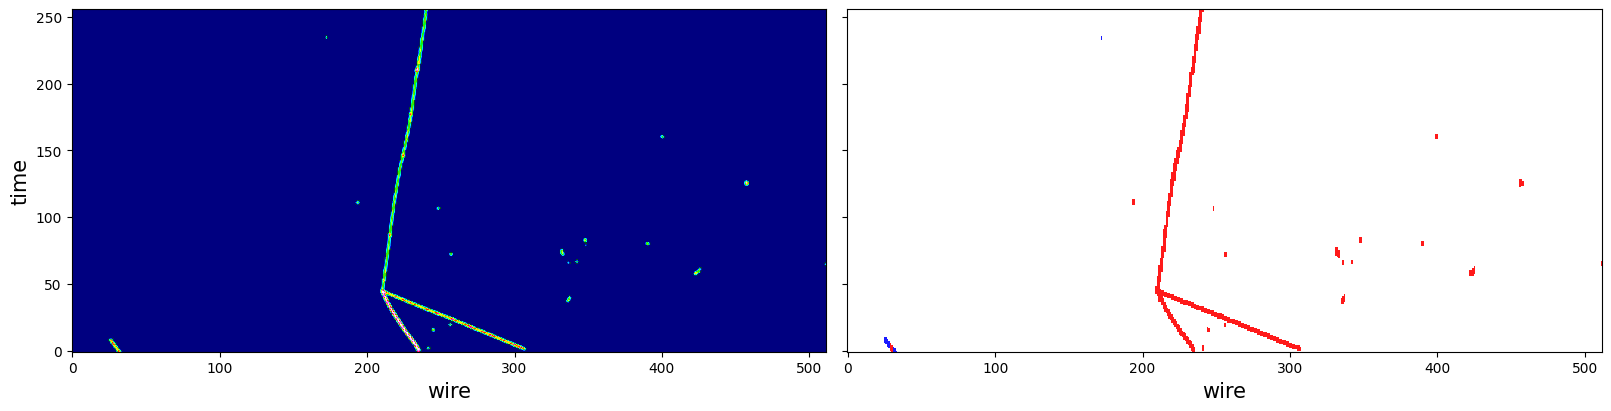

sig_in_window / sig_in_evt = 1225 / 2108 | bkg_in_window = 971 | total_in_window = 2196


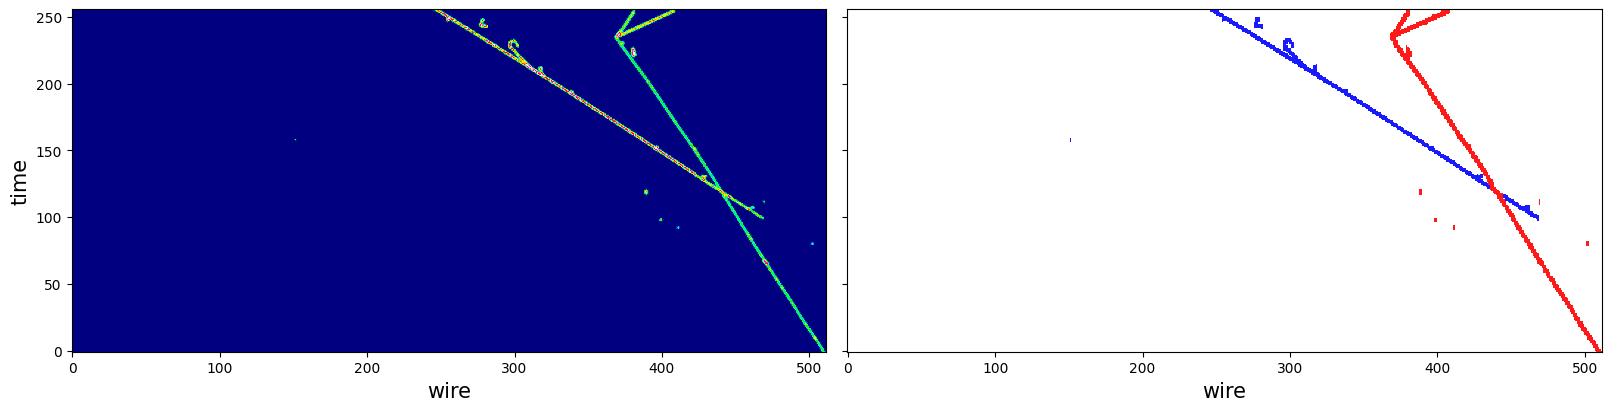

sig_in_window / sig_in_evt = 1175 / 1228 | bkg_in_window = 1182 | total_in_window = 2357


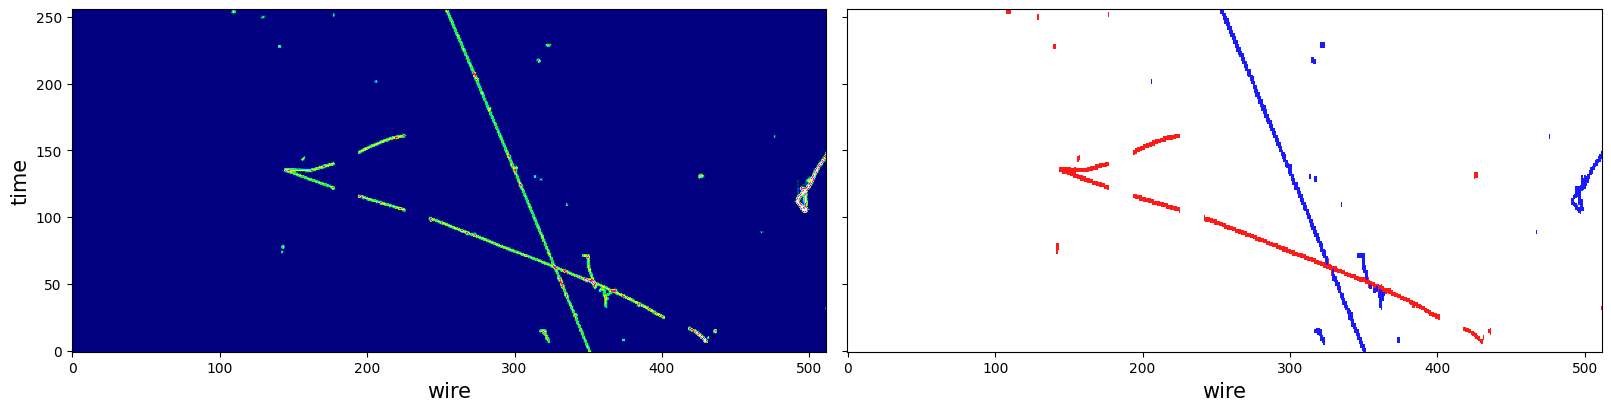

sig_in_window / sig_in_evt = 1986 / 2312 | bkg_in_window = 466 | total_in_window = 2452


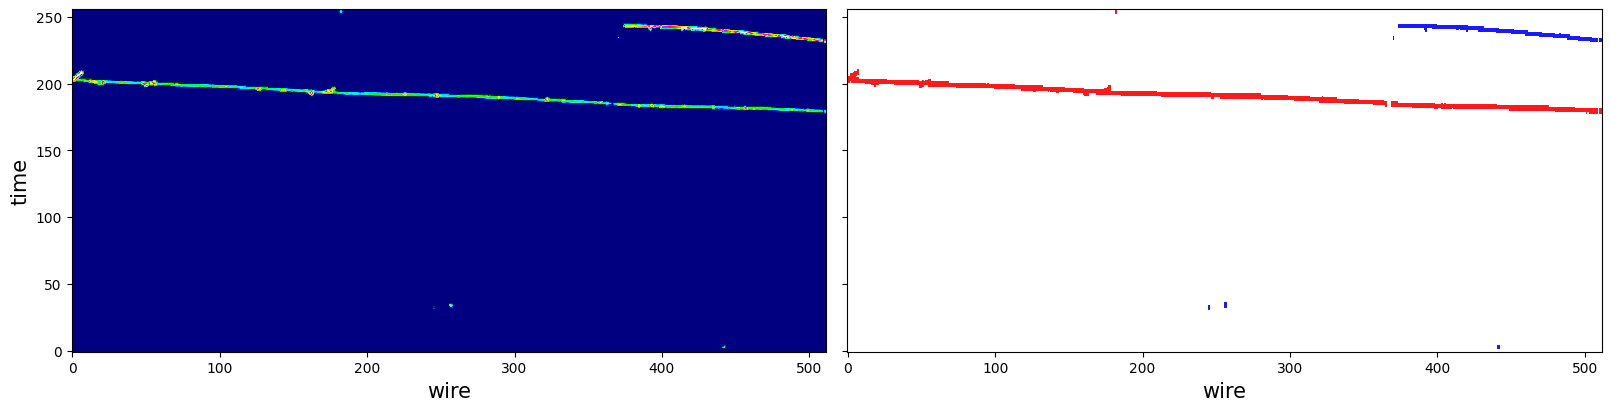

sig_in_window / sig_in_evt = 1882 / 10117 | bkg_in_window = 108 | total_in_window = 1990


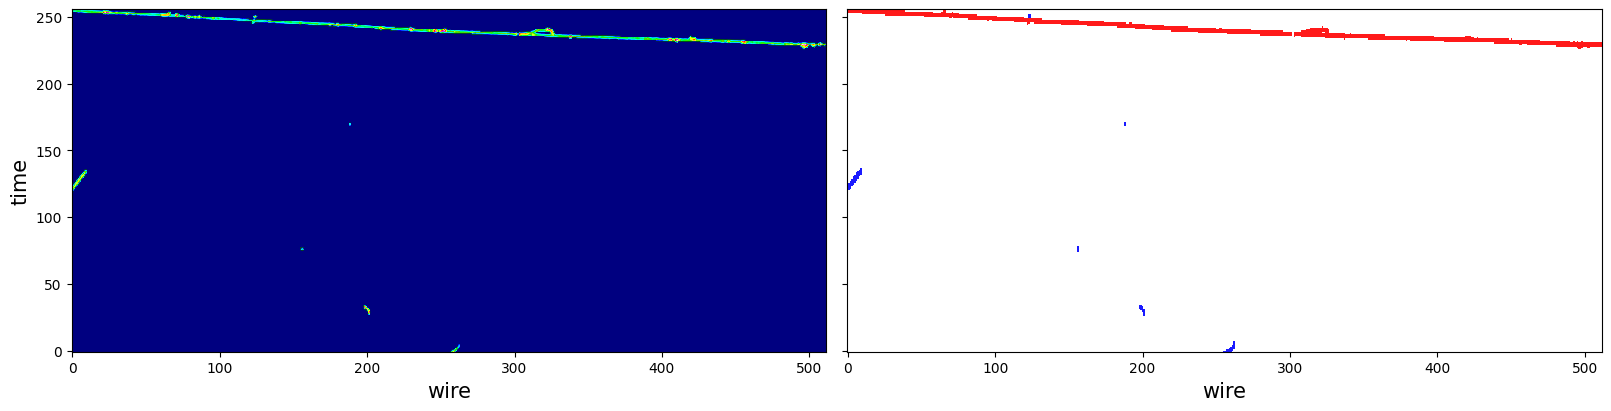

sig_in_window / sig_in_evt = 0 / 1638 | bkg_in_window = 11 | total_in_window = 11


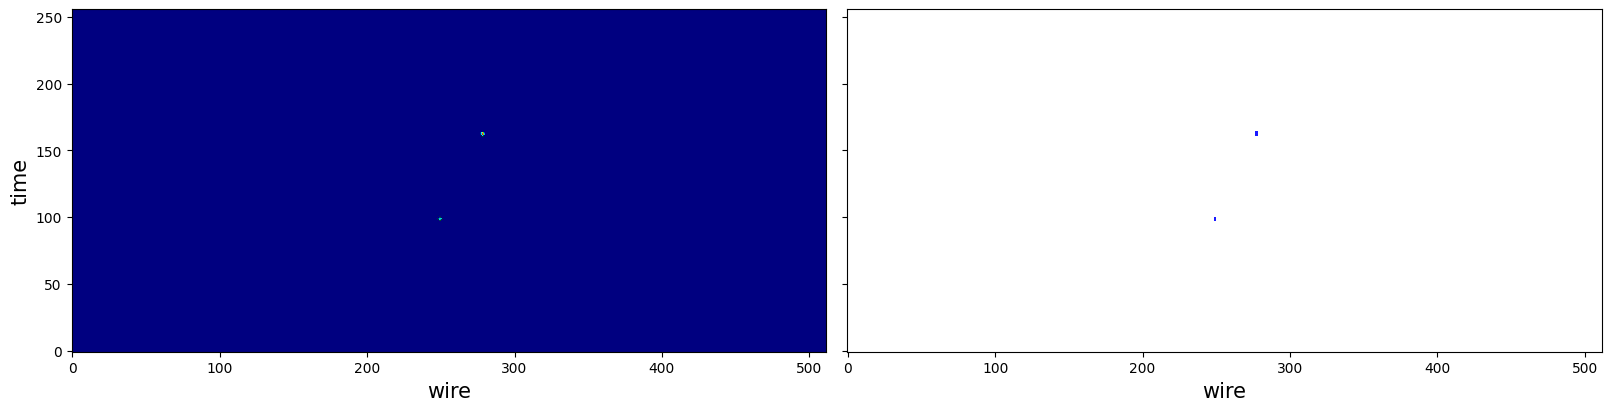

sig_in_window / sig_in_evt = 0 / 1638 | bkg_in_window = 1193 | total_in_window = 1193


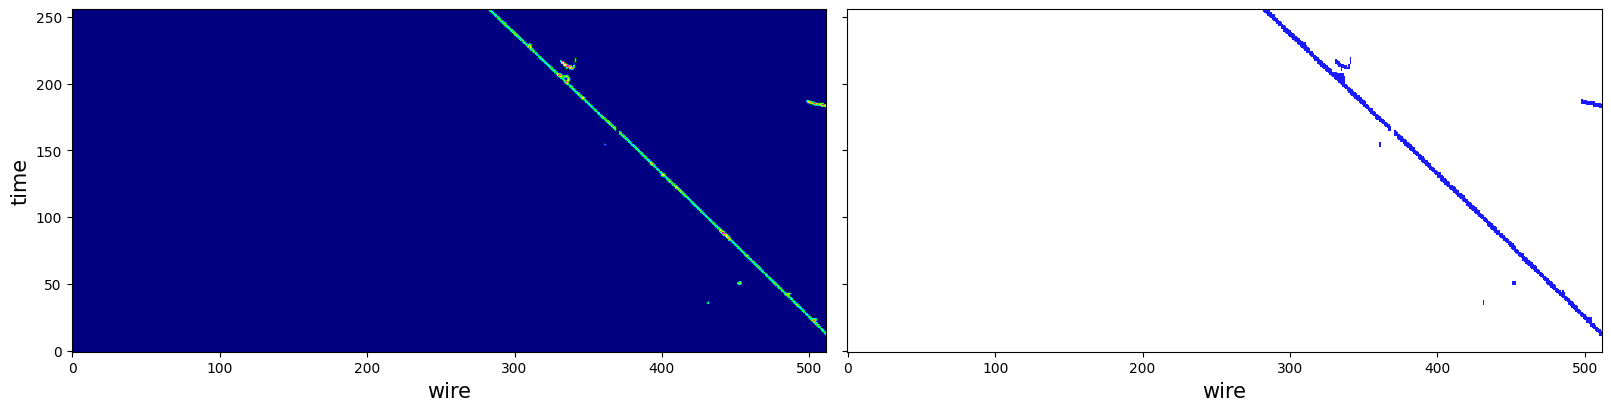

sig_in_window / sig_in_evt = 0 / 1638 | bkg_in_window = 79 | total_in_window = 79


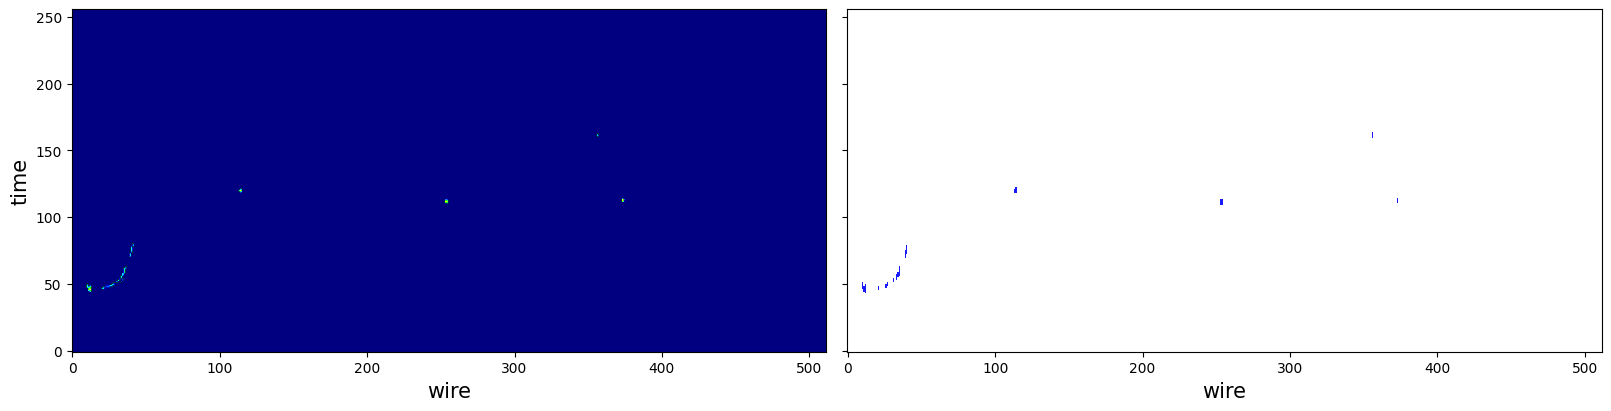

sig_in_window / sig_in_evt = 0 / 1638 | bkg_in_window = 1539 | total_in_window = 1539


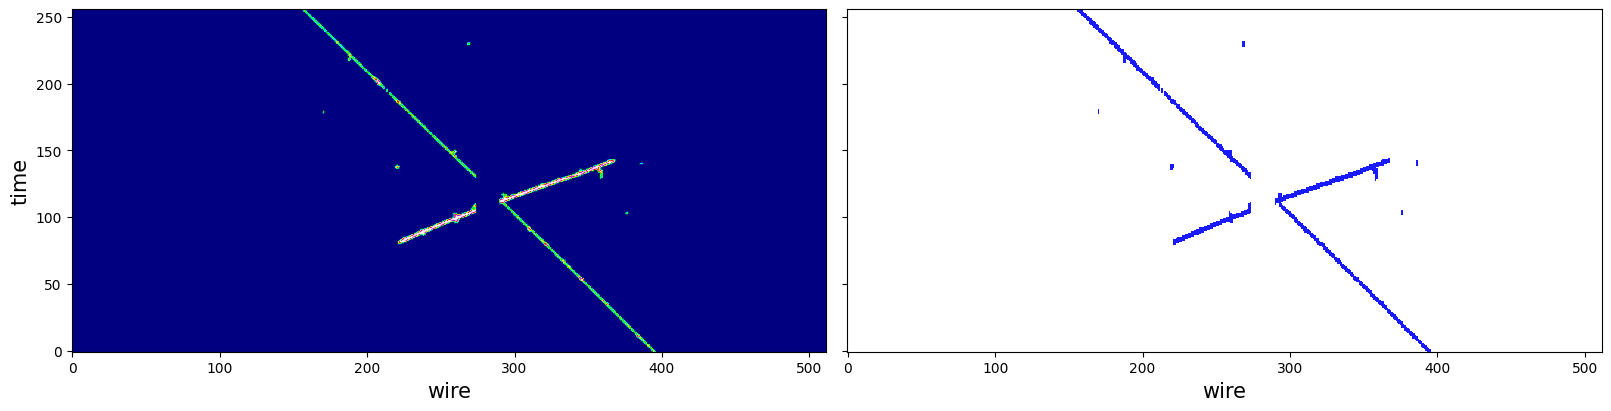

sig_in_window / sig_in_evt = 0 / 1638 | bkg_in_window = 521 | total_in_window = 521


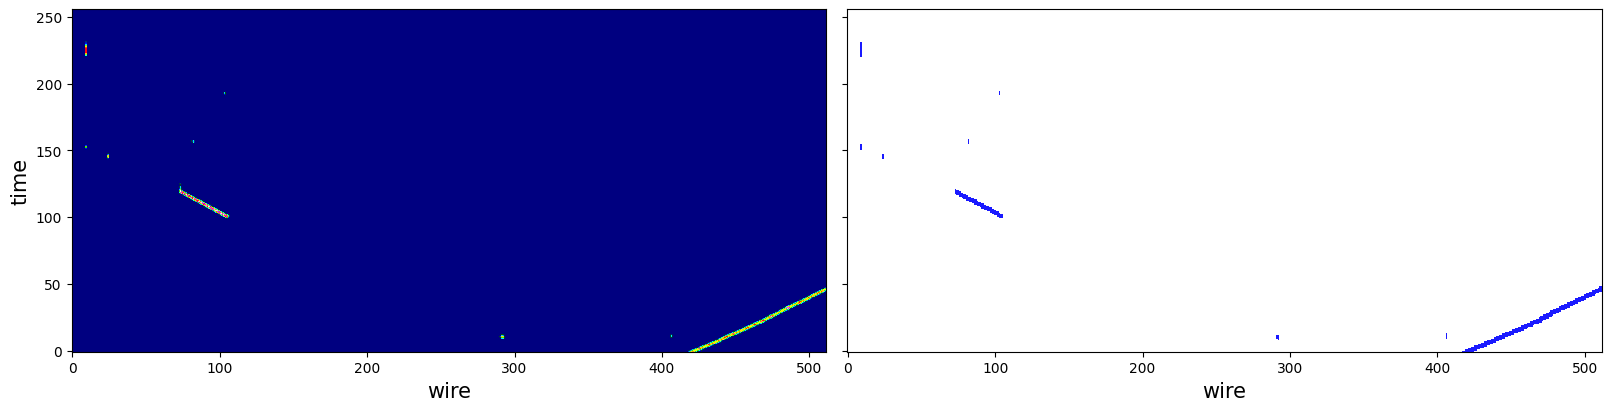

In [3]:
preview_patches("datasets/neutrino/data_inclusive_plane2_slim_500_patches_sig_t256w512.h5", max_examples=5, start_idx=0, cmap='gist_ncar', vmin=0, vmax=100)
preview_patches("datasets/neutrino/data_inclusive_plane2_slim_500_patches_bkg_t256w512.h5", max_examples=5, start_idx=0, cmap='gist_ncar', vmin=0, vmax=100)

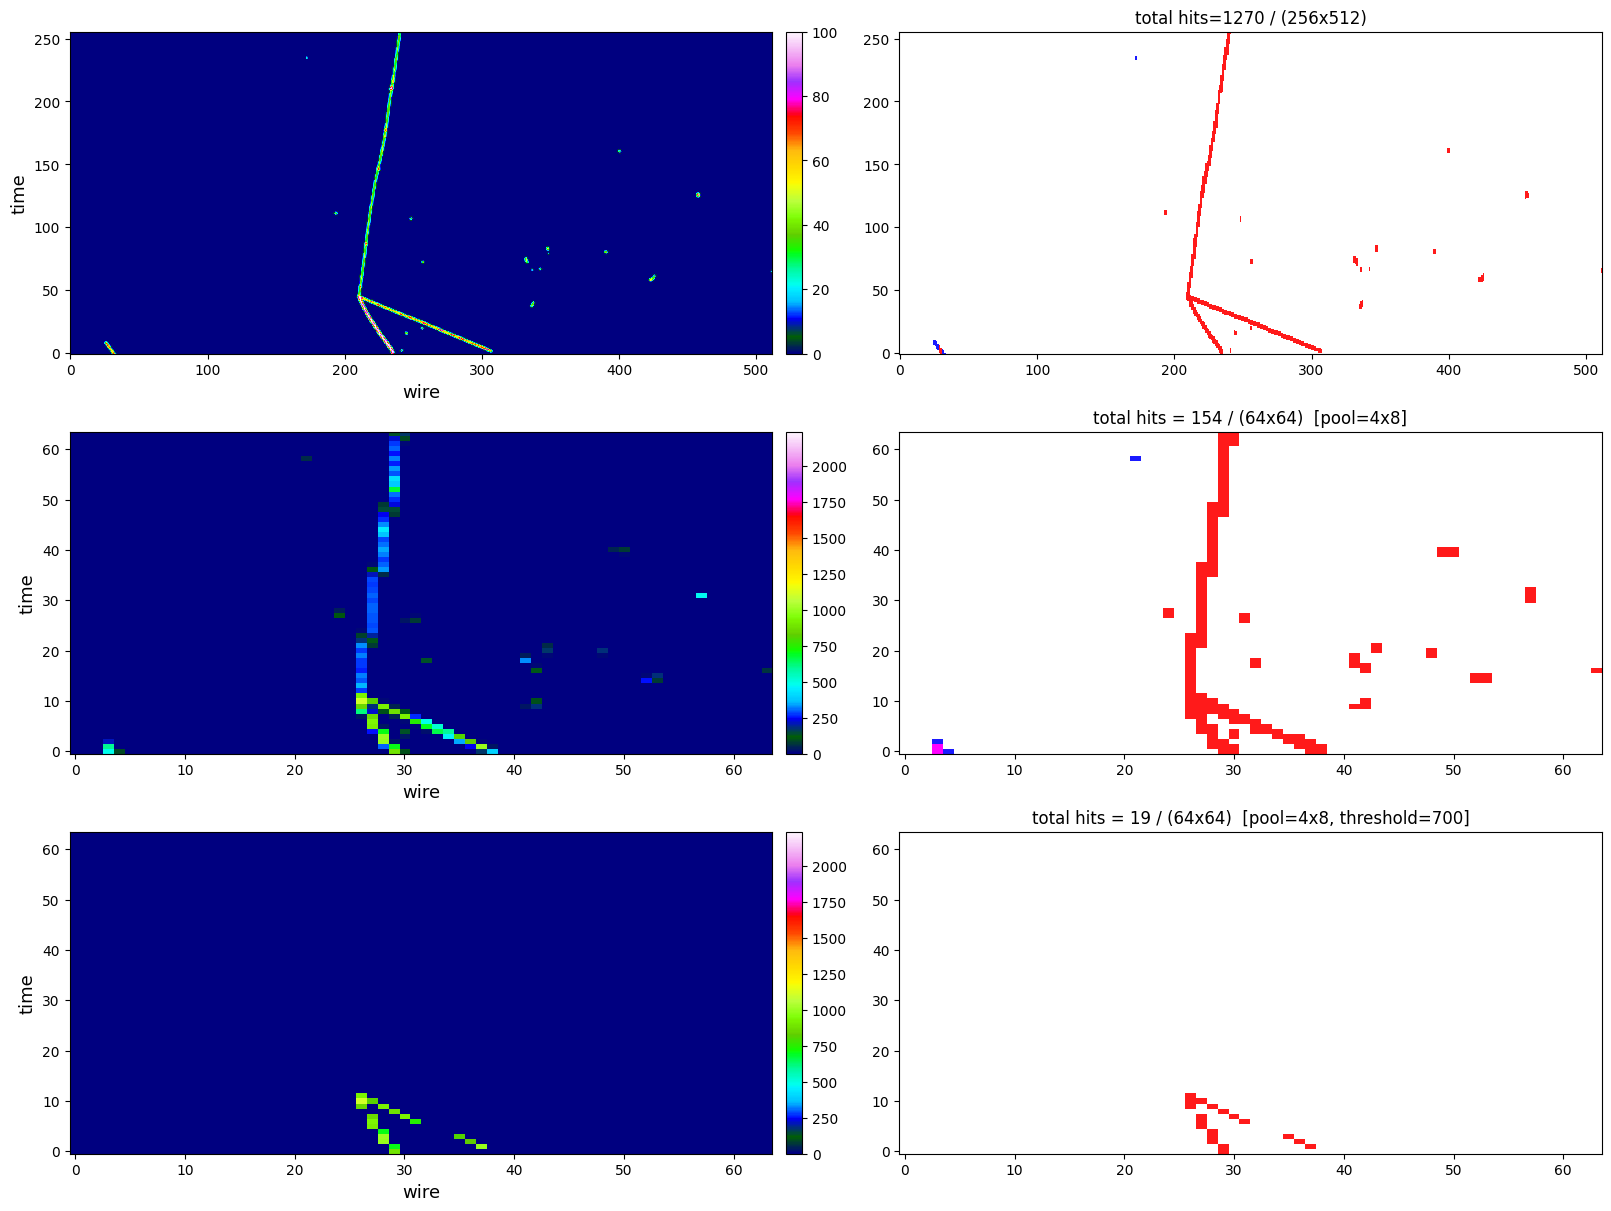

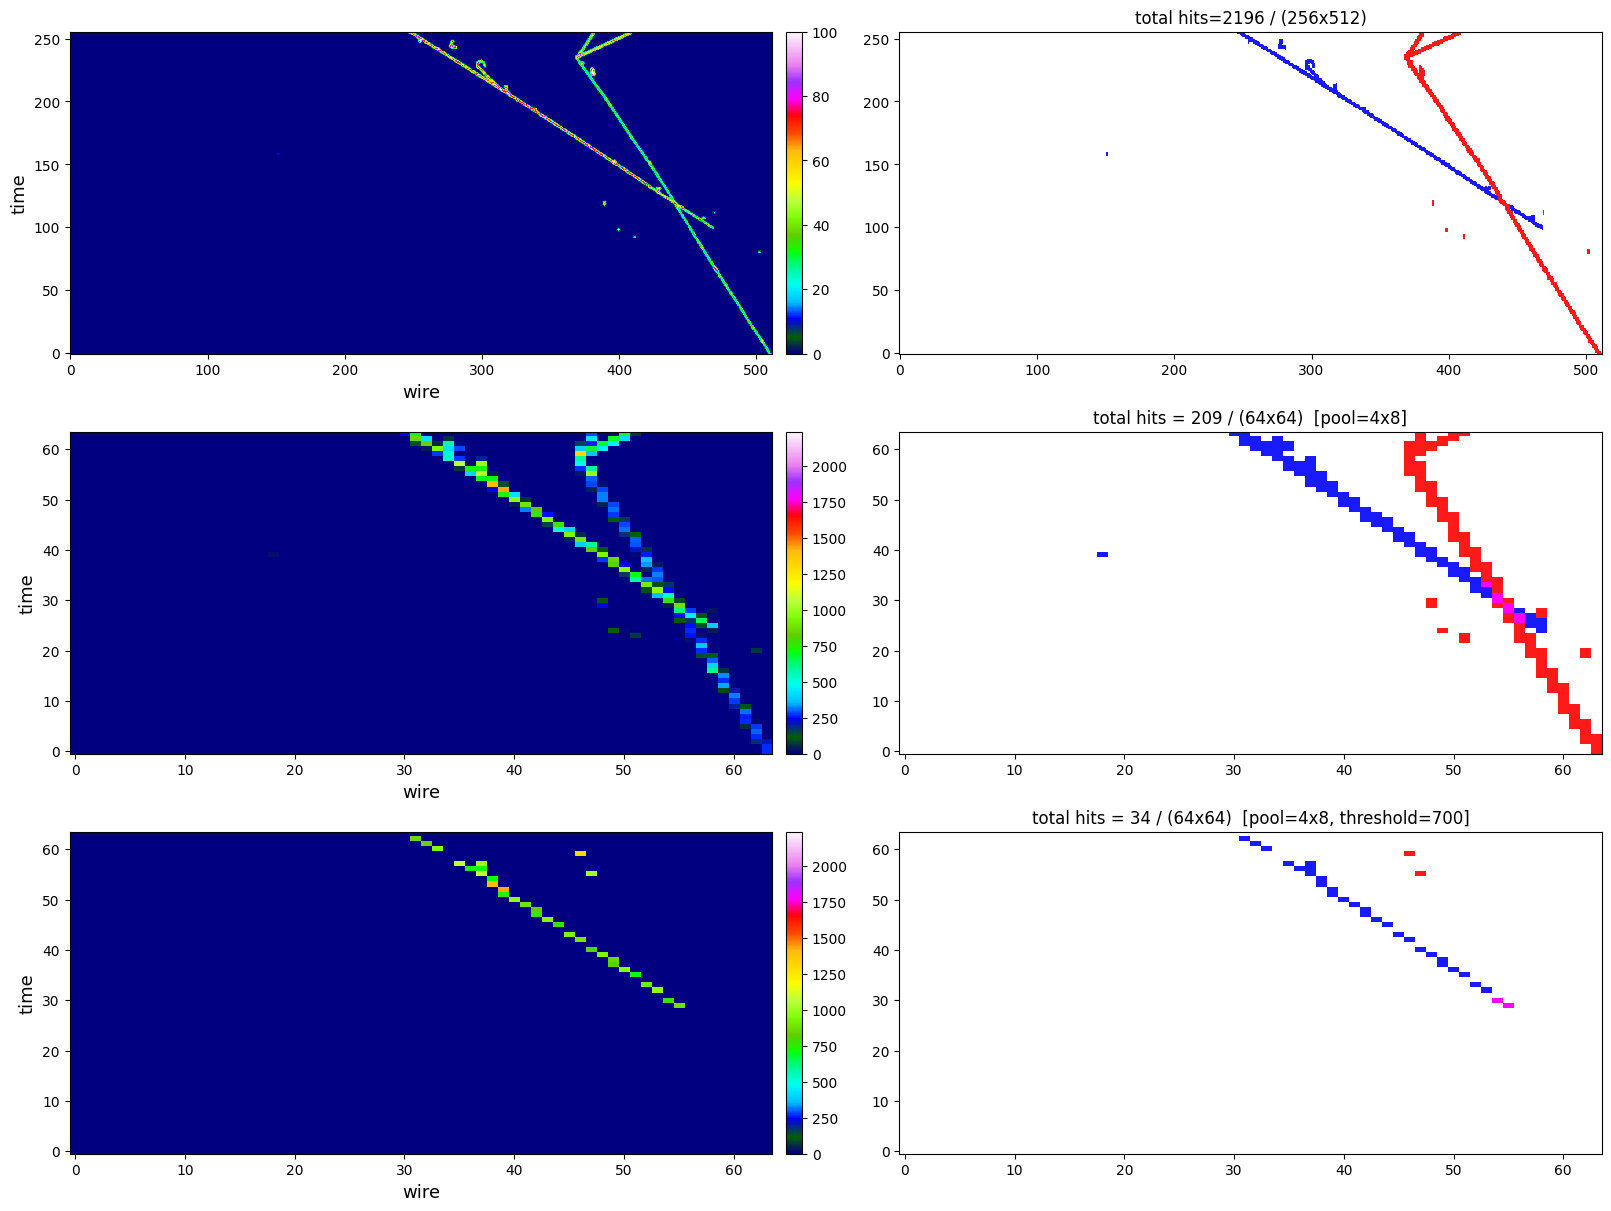

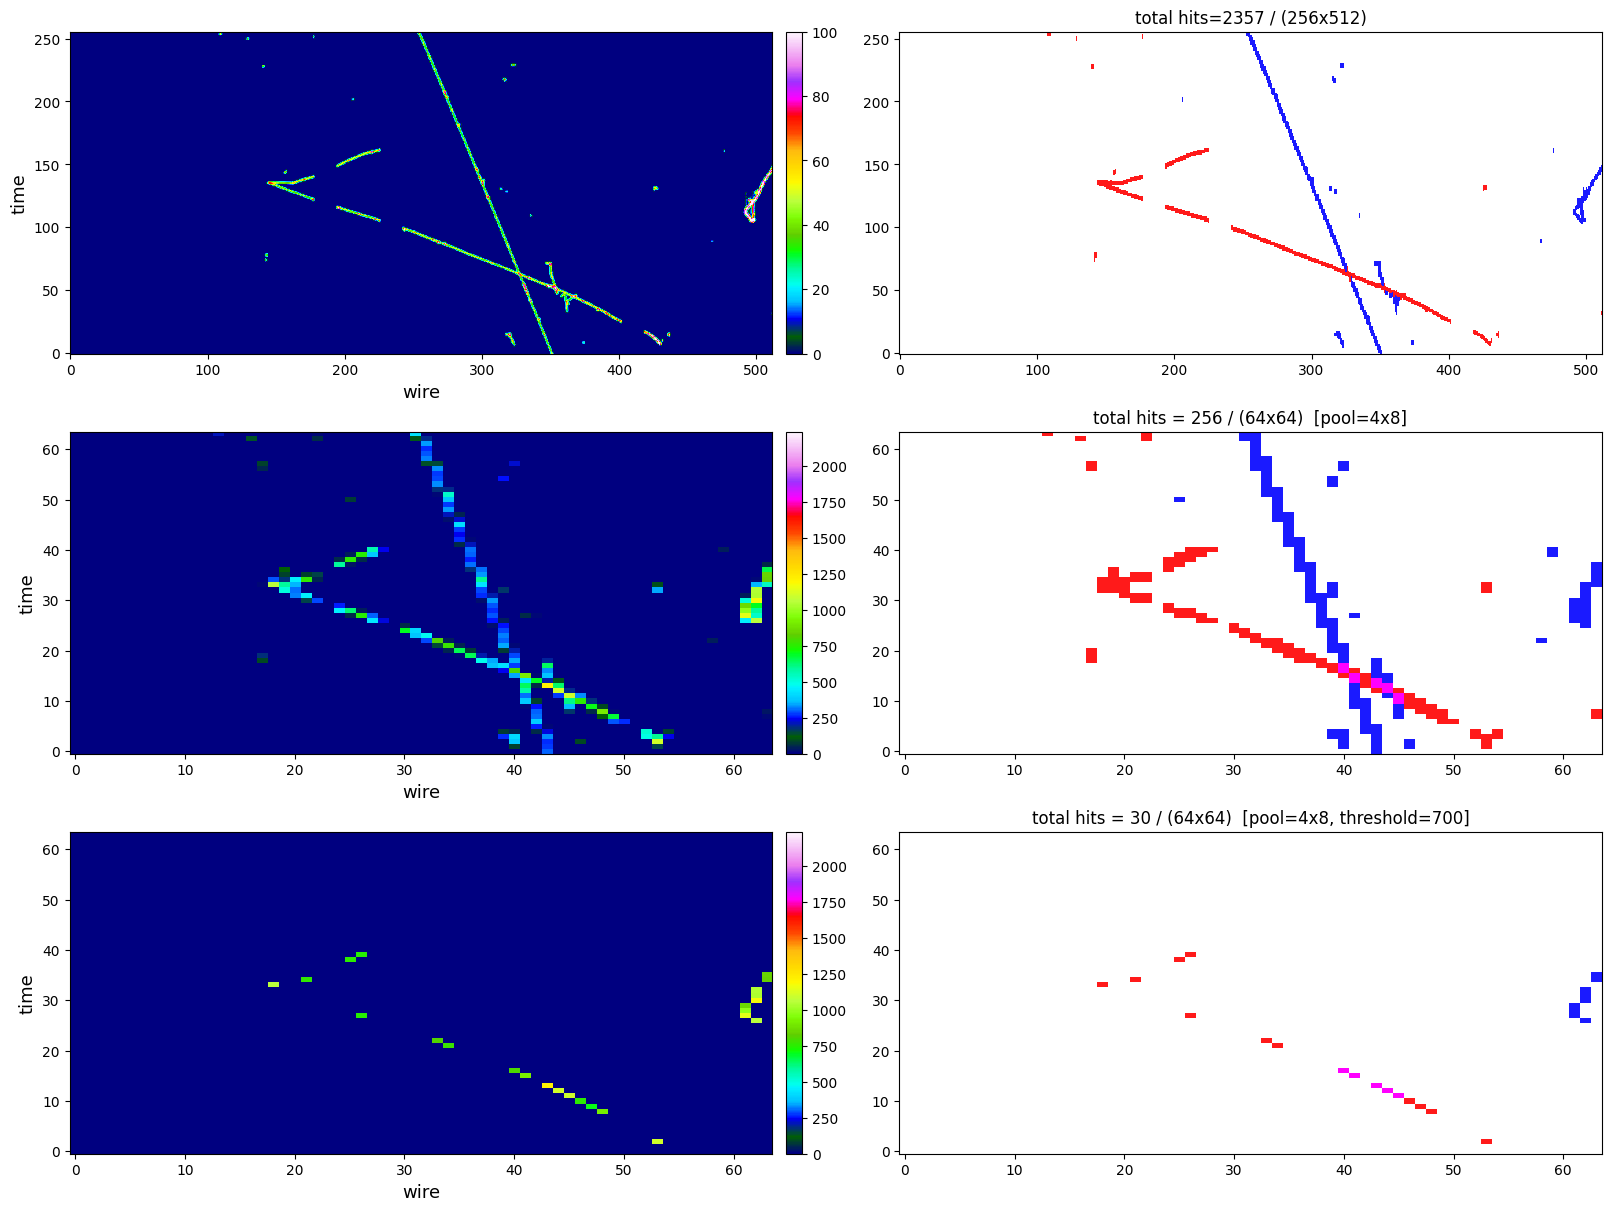

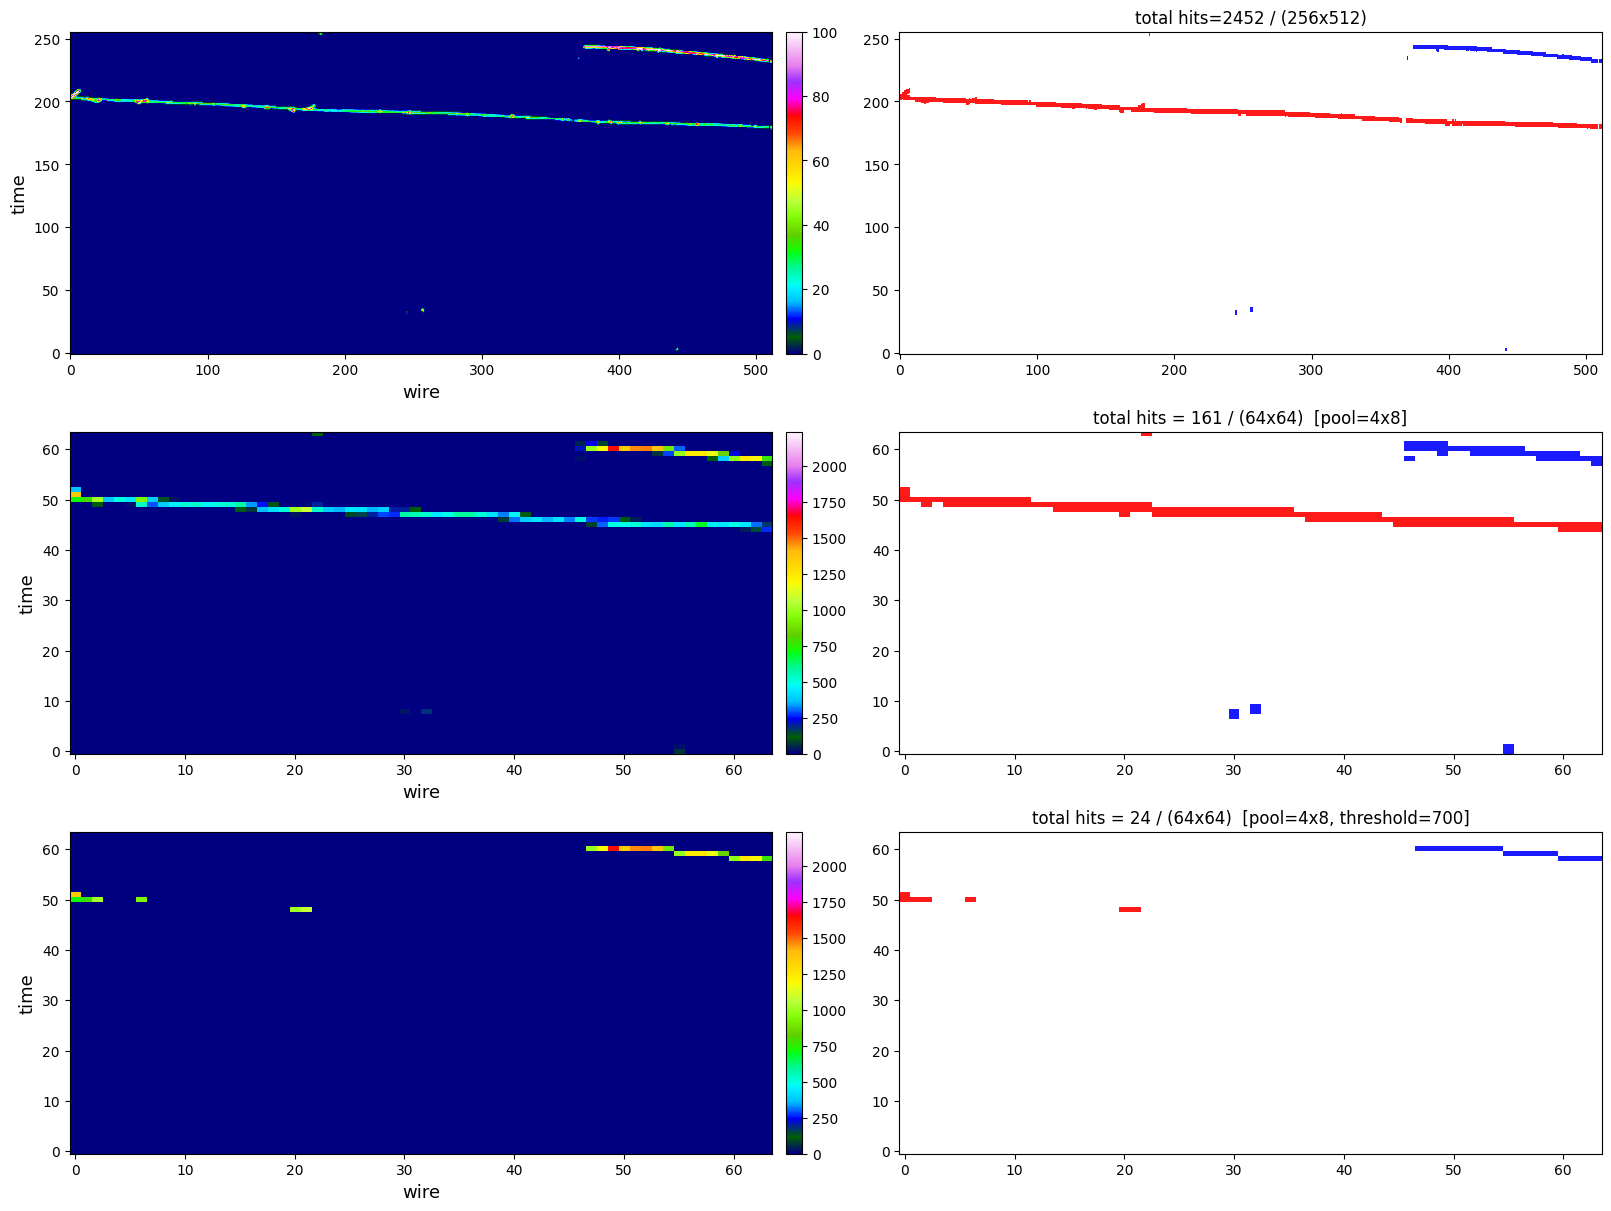

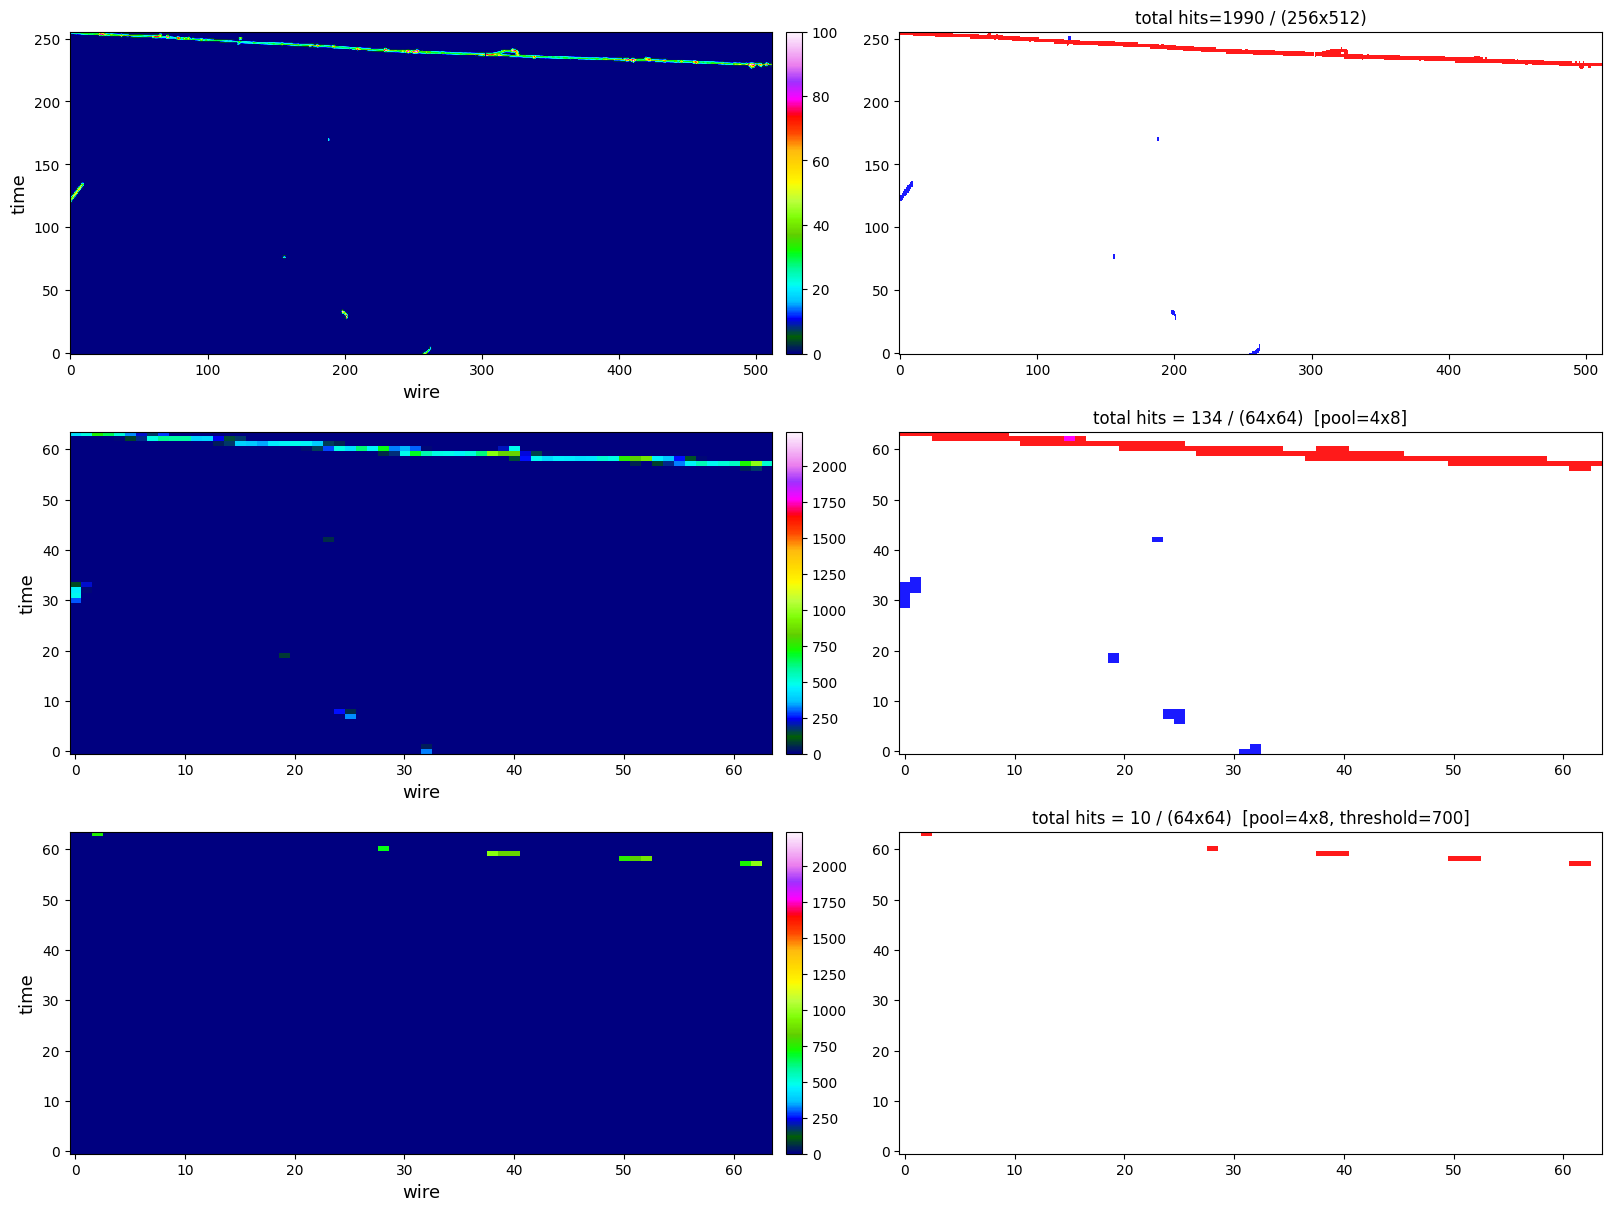

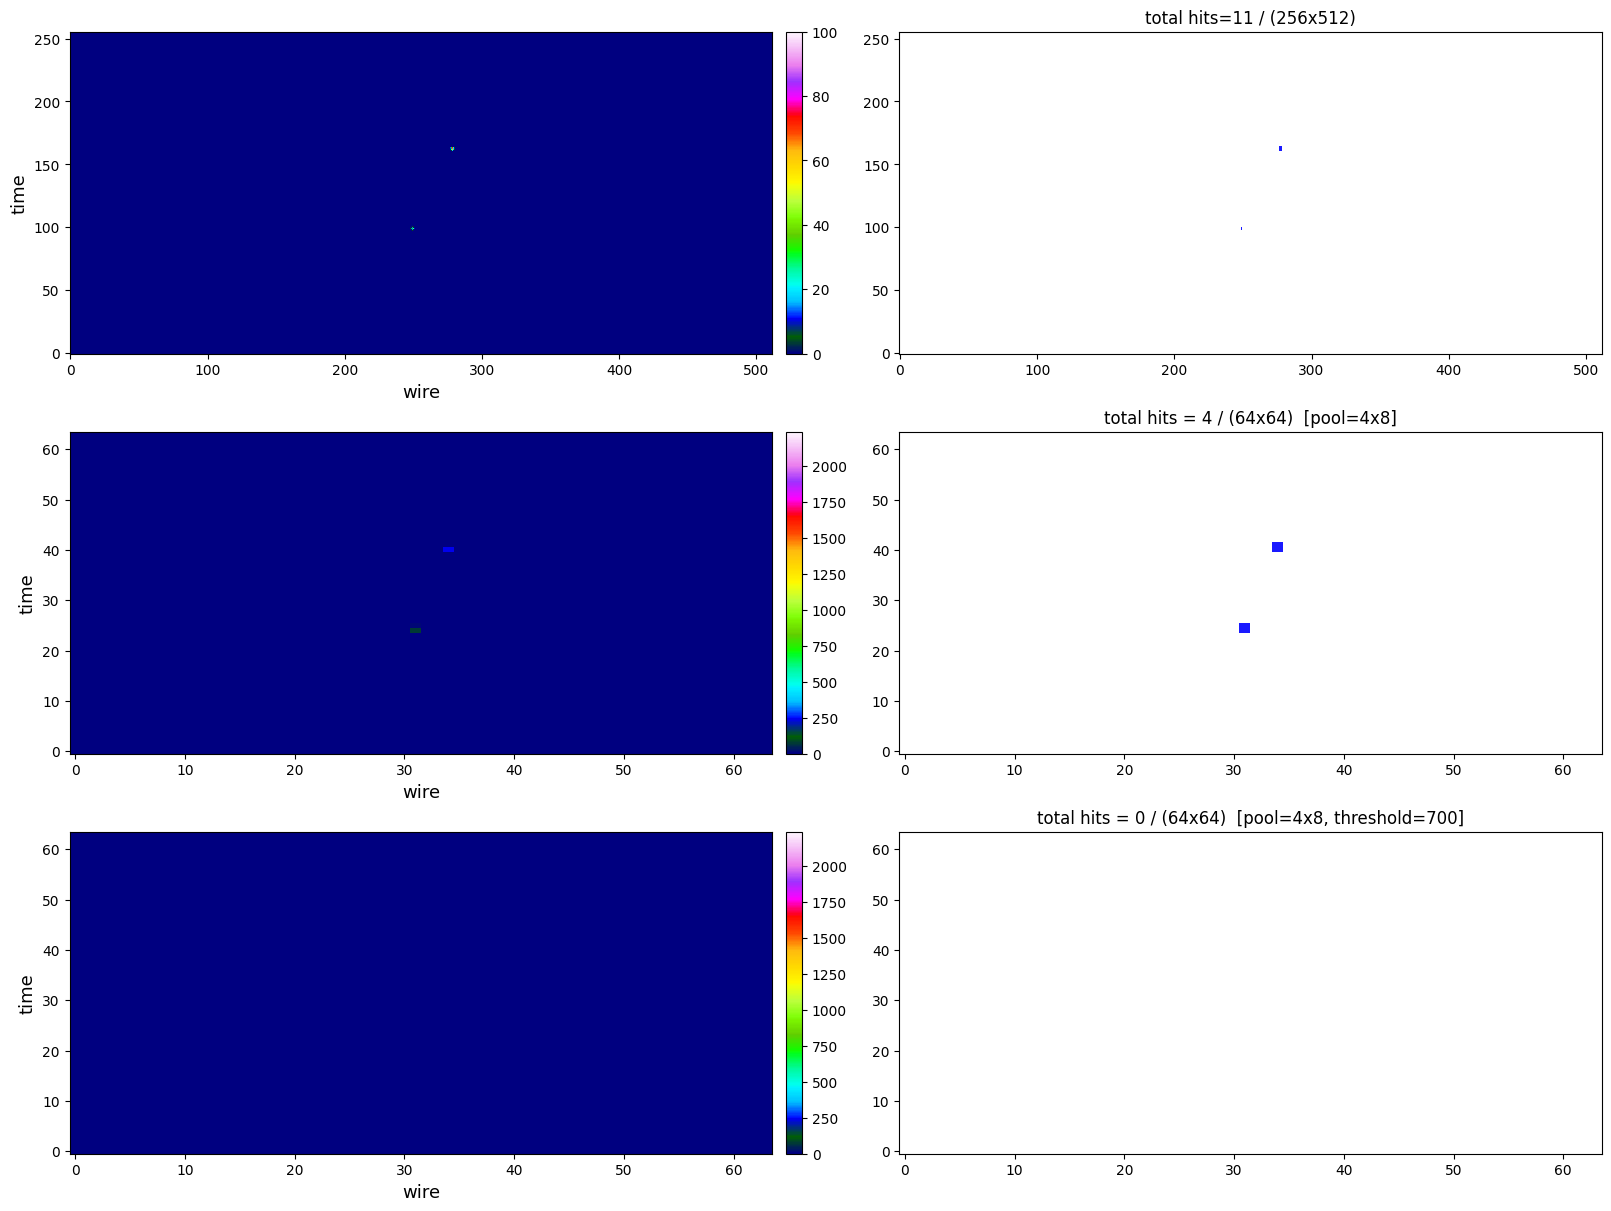

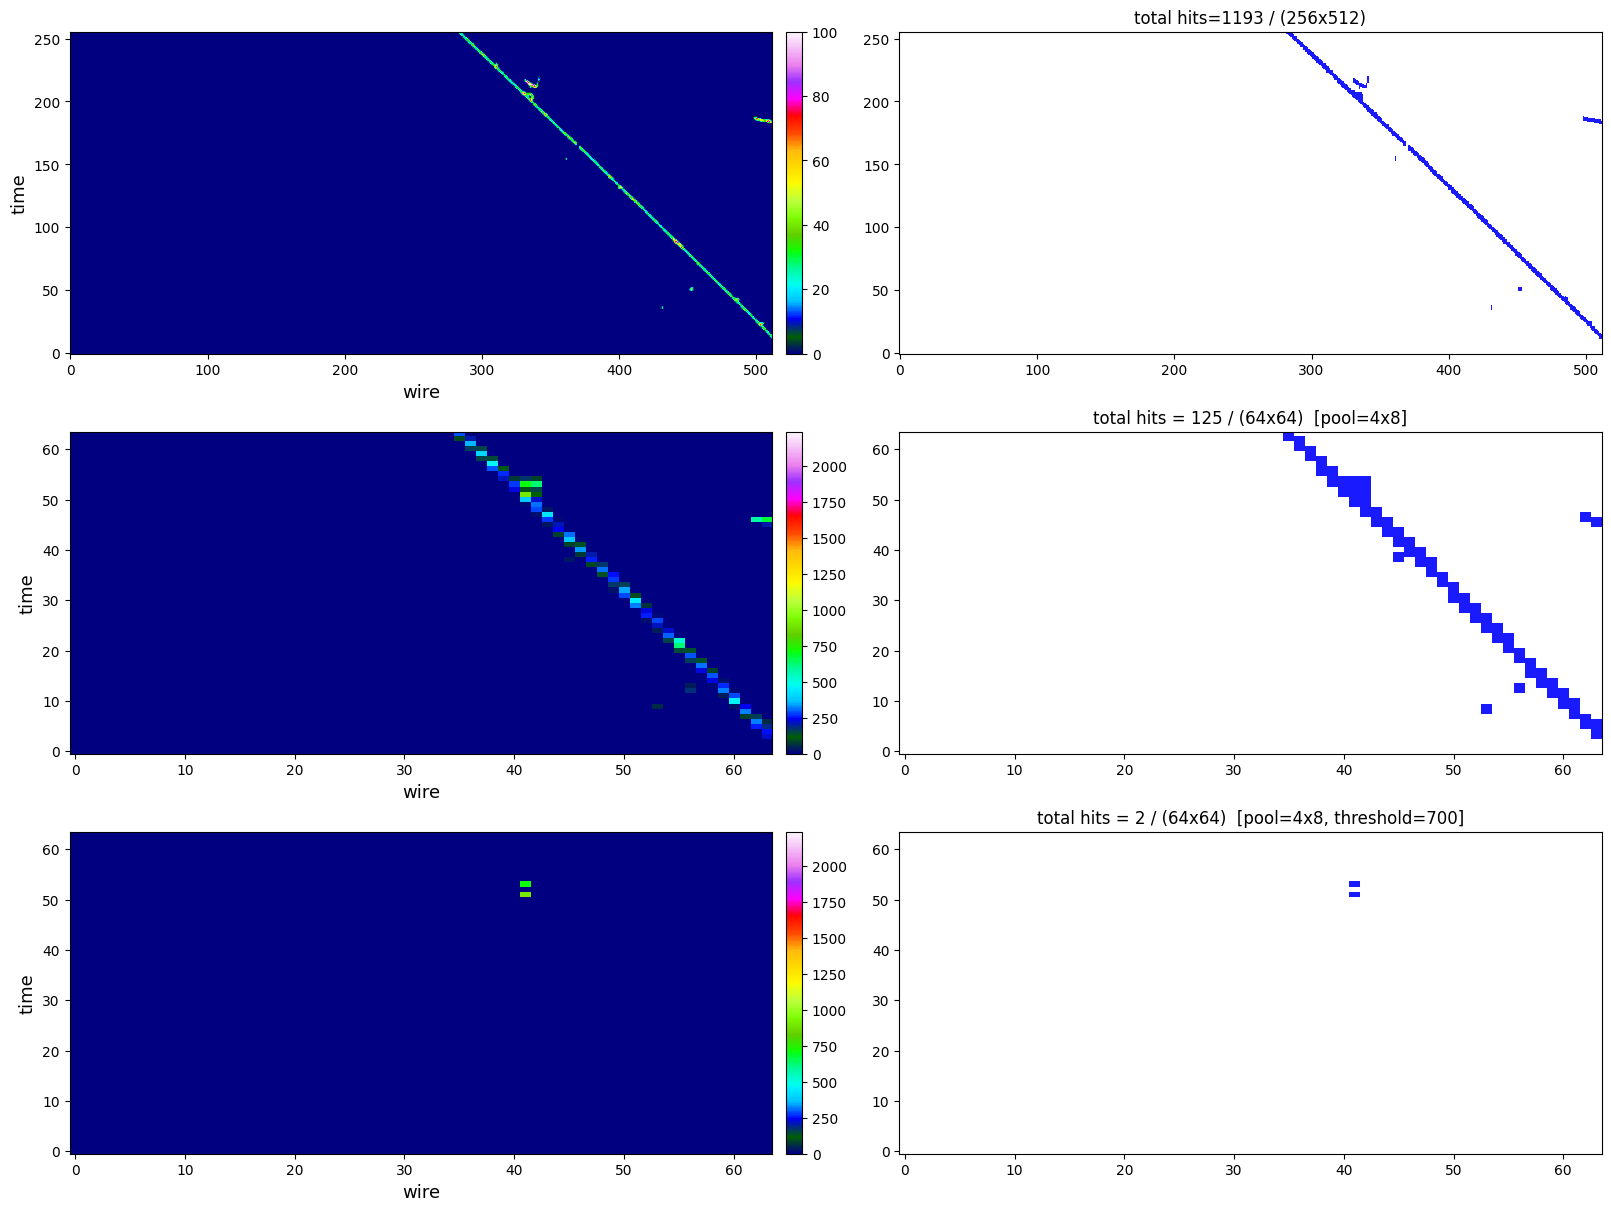

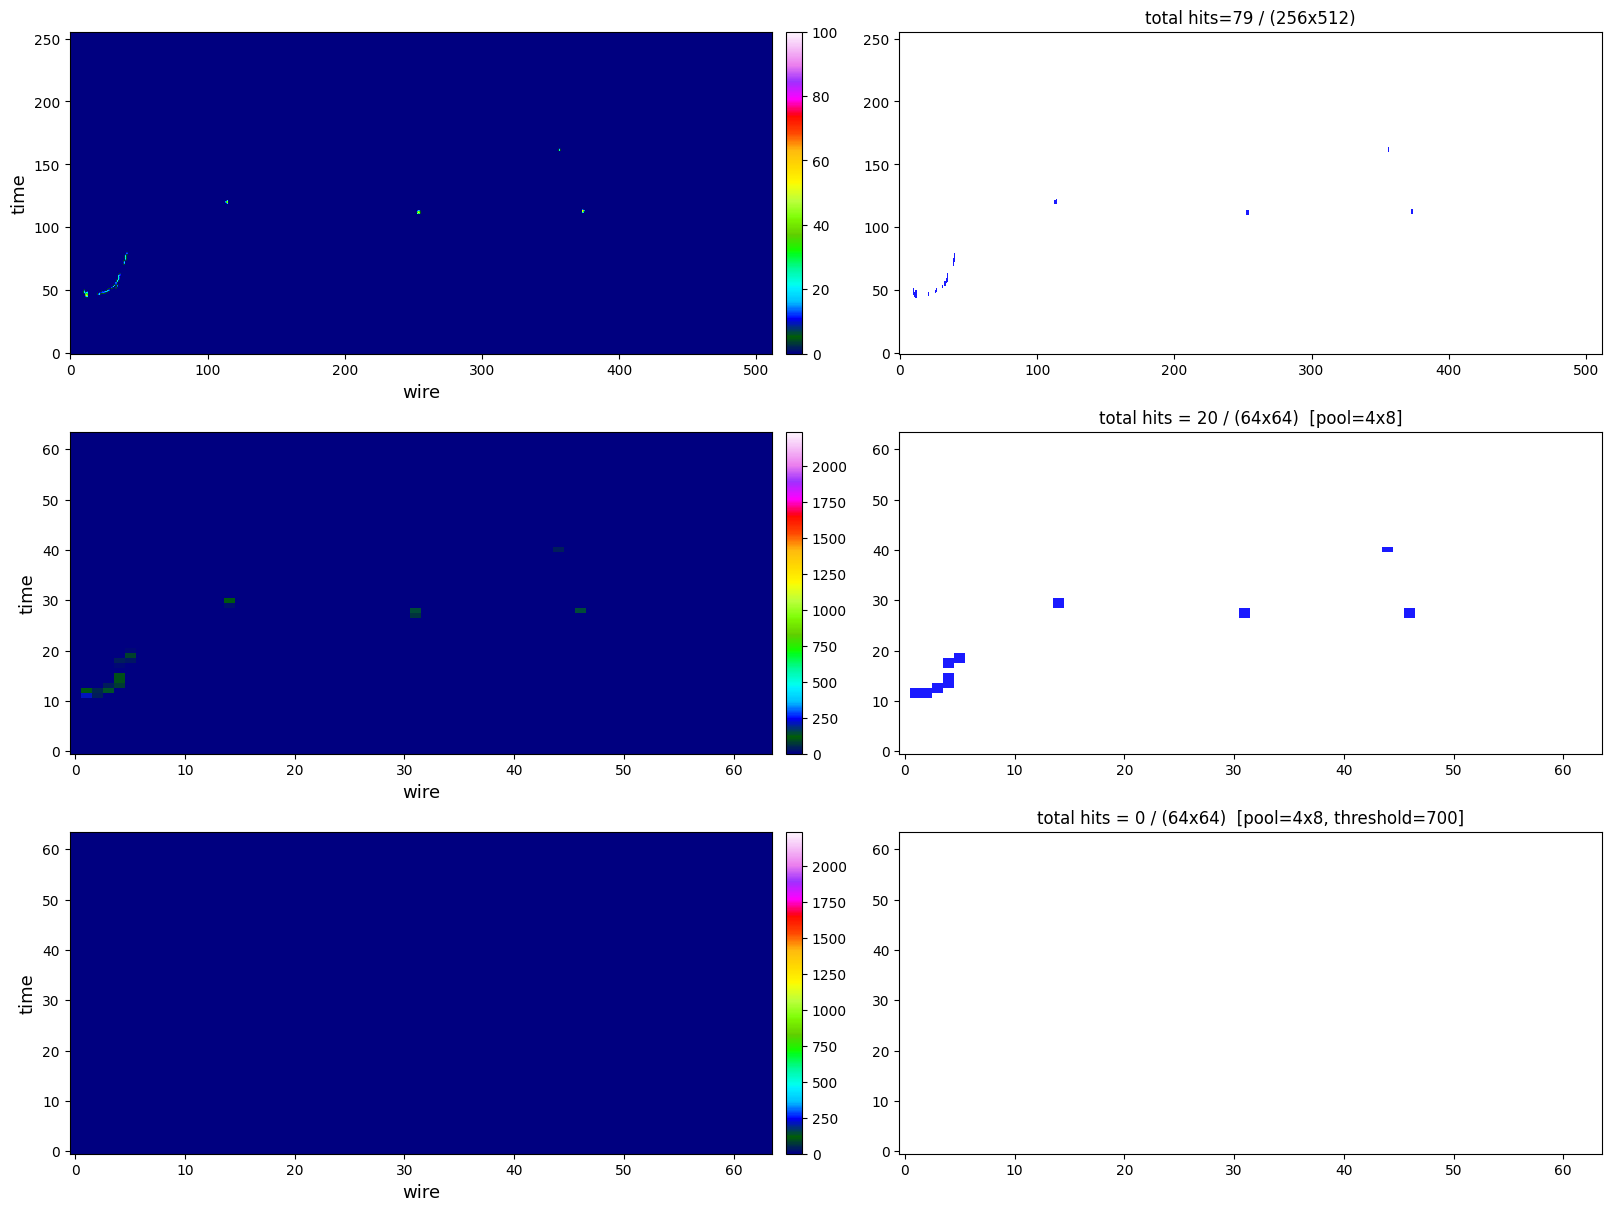

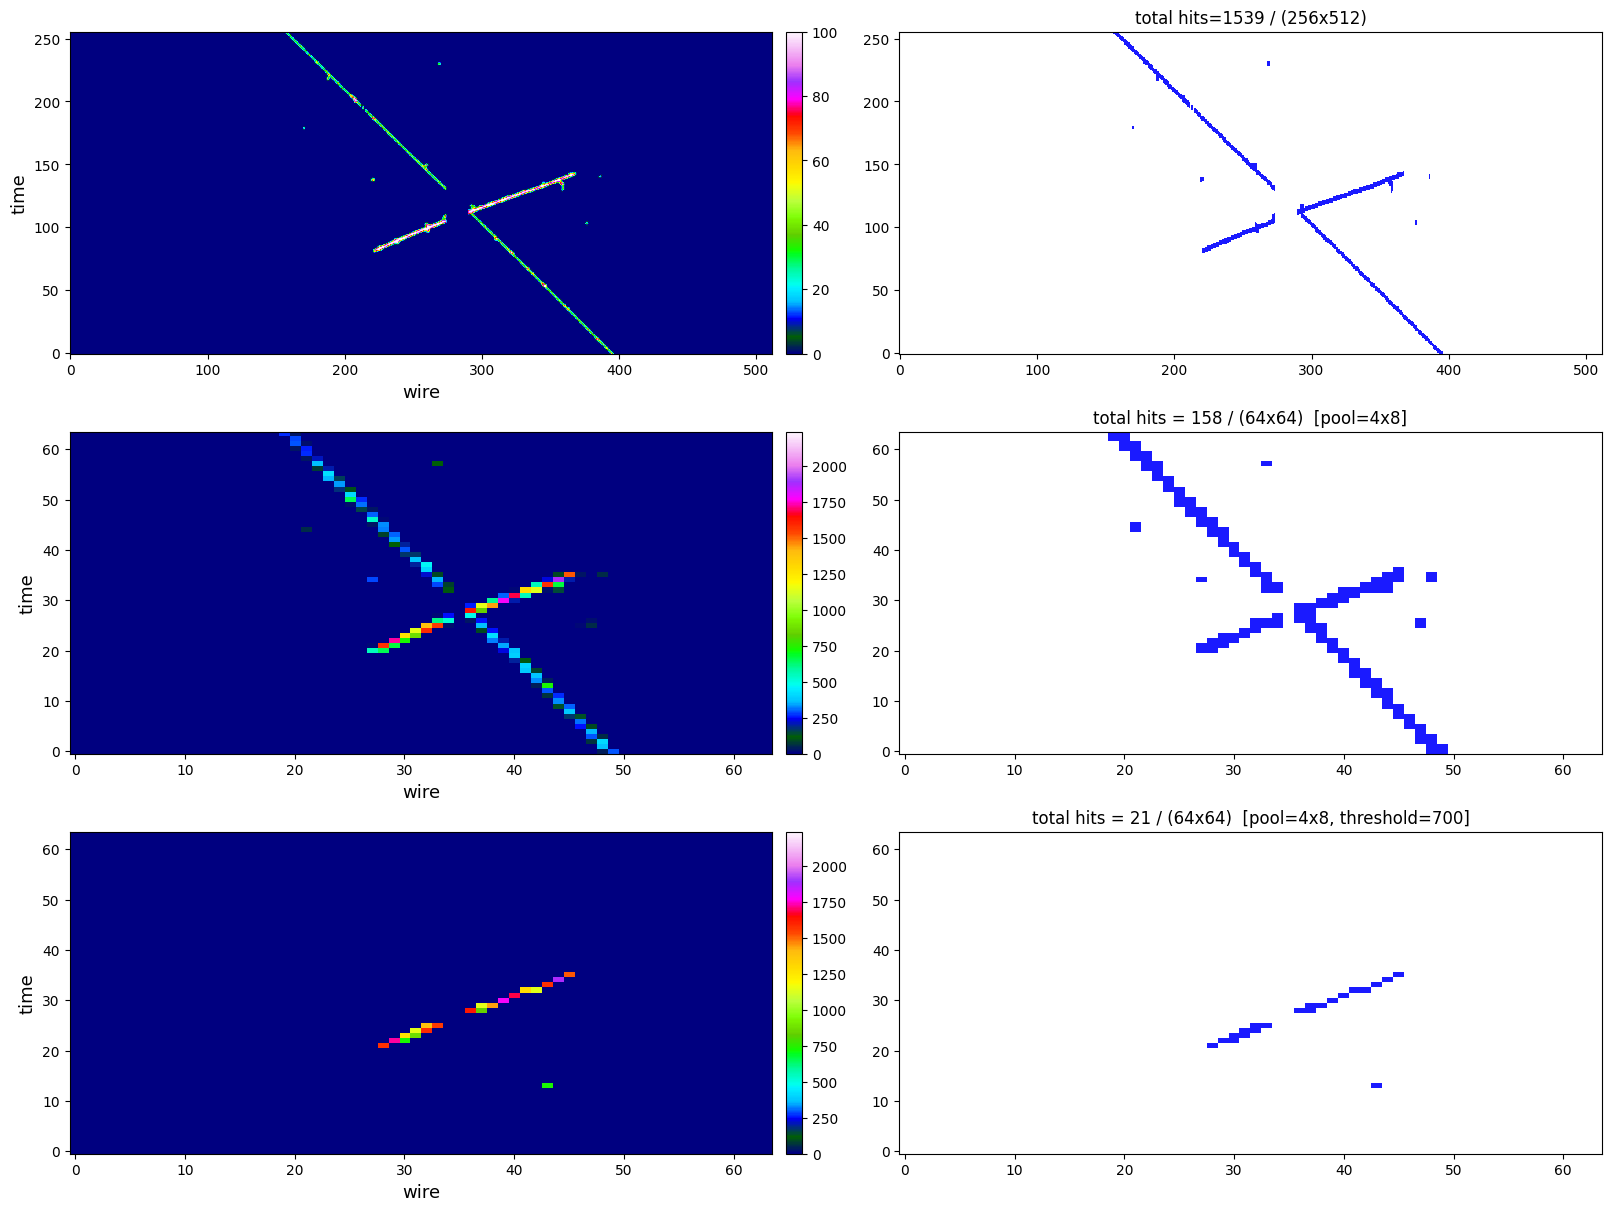

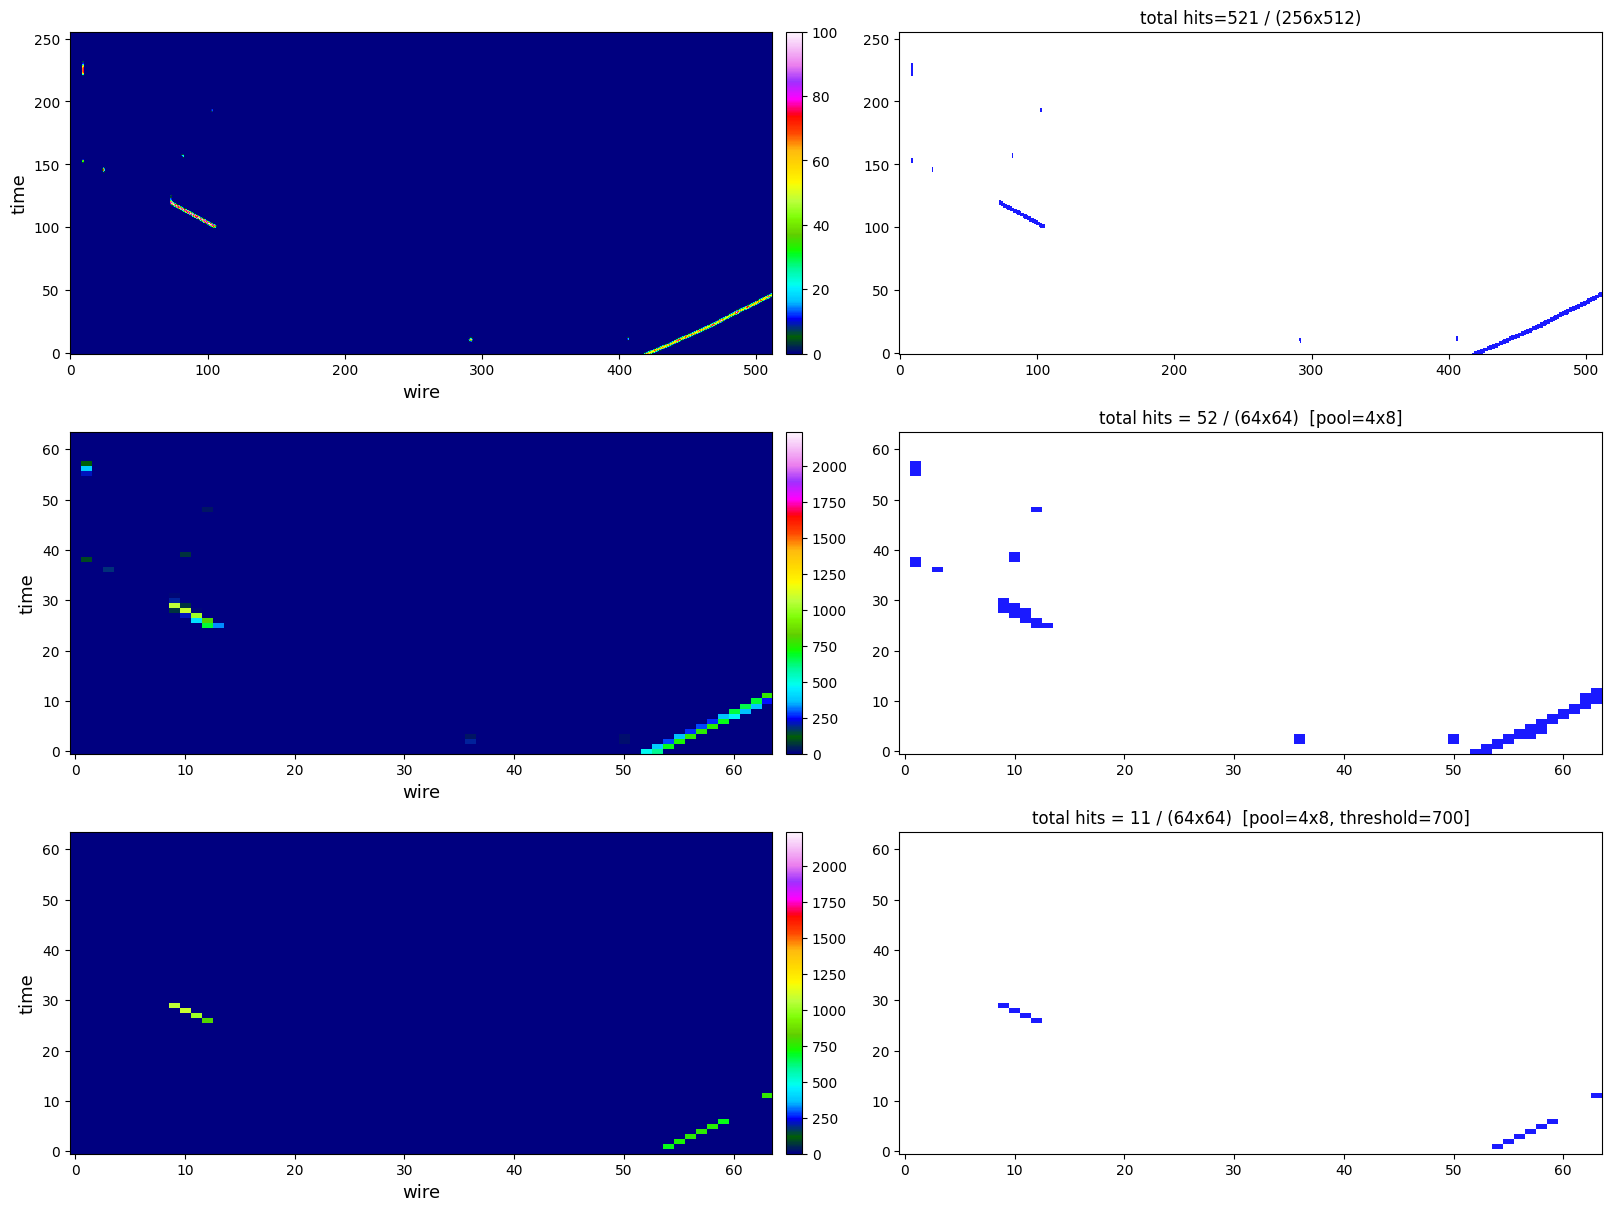

In [4]:
thr=700; pool_t=4; pool_w=8; vmax_pool=pool_t*pool_w*100*0.7
preview_patches_with_pooling("datasets/neutrino/data_inclusive_plane2_slim_500_patches_sig_t256w512.h5",
    max_examples=5, start_idx=0, pool_t=pool_t, pool_w=pool_w, thr=thr,
    vmin_raw=0,vmax_raw=100,  vmin_pool=0,vmax_pool=vmax_pool,  vmin_thr=0,vmax_thr=vmax_pool)
preview_patches_with_pooling("datasets/neutrino/data_inclusive_plane2_slim_500_patches_bkg_t256w512.h5",
    max_examples=5, start_idx=0, pool_t=pool_t, pool_w=pool_w, thr=thr,
    vmin_raw=0,vmax_raw=100,  vmin_pool=0,vmax_pool=vmax_pool,  vmin_thr=0,vmax_thr=vmax_pool)

In [5]:
sig_files = ["datasets/neutrino/data_inclusive_plane2_slim_500_patches_sig_t256w512.h5",
             "datasets/neutrino/data_inclusive_plane1_slim_500_patches_sig_t256w512.h5",
             "datasets/neutrino/data_inclusive_plane0_slim_500_patches_sig_t256w512.h5",
             "datasets/neutrino/data_nue_plane2_slim_500_patches_sig_t256w512.h5",
             "datasets/neutrino/data_nue_plane1_slim_500_patches_sig_t256w512.h5",
             "datasets/neutrino/data_nue_plane0_slim_500_patches_sig_t256w512.h5",
]
bkg_files = ["datasets/neutrino/data_inclusive_plane2_slim_500_patches_bkg_t256w512.h5",
             #"datasets/neutrino/data_inclusive_plane1_slim_500_patches_bkg_t256w512.h5",
             #"datasets/neutrino/data_inclusive_plane0_slim_500_patches_bkg_t256w512.h5",
             "datasets/neutrino/data_nue_plane2_slim_500_patches_bkg_t256w512.h5",
             #"datasets/neutrino/data_nue_plane1_slim_500_patches_bkg_t256w512.h5",
             #"datasets/neutrino/data_nue_plane0_slim_500_patches_bkg_t256w512.h5",
]

X_list, y_list = [], []
sig_list, bkg_list = [], []

for file_group, label in [(sig_files, 1), (bkg_files, 0)]:
    for path in file_group:
        with h5py.File(path, "r") as g:
            imgs = g["image"][:]
            sigm = g["sigmask"][:]
            bkgm = g["bkgmask"][:]

            T, W = imgs.shape[1], imgs.shape[2]
            target_shape = (T, W)

            imgs = imgs[..., np.newaxis].astype(np.float32)
            sigm = sigm[..., np.newaxis].astype(np.uint8)
            bkgm = bkgm[..., np.newaxis].astype(np.uint8)

            X_list.append(imgs)
            y_list.append(np.full((imgs.shape[0], 1), label, dtype=np.int64))
            sig_list.append(sigm)
            bkg_list.append(bkgm)

            print(f"{imgs.shape[0]} patches from {path} (label={label})")

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
mask_sig = np.concatenate(sig_list, axis=0)
mask_bkg = np.concatenate(bkg_list, axis=0)

print("\nshapes:")
print("X       :", X.shape)
print("y       :", y.shape, ", counts:", np.unique(y, return_counts=True))
print("mask_sig:", mask_sig.shape)
print("mask_bkg:", mask_bkg.shape)

# data pooling
pool_t = 4
pool_w = 8
thr = 700
batch = 512

N, T, W, C = X.shape
new_T = T // pool_t
new_W = W // pool_w

X_out = np.empty((N, new_T, new_W, C), dtype=X.dtype)
mask_sig_out = np.empty((N, new_T, new_W, C), dtype=np.uint8)
mask_bkg_out = np.empty((N, new_T, new_W, C), dtype=np.uint8)

for i0 in range(0, N, batch):
    i1 = min(i0 + batch, N)
    x = X[i0:i1]
    ms = mask_sig[i0:i1]
    mb = mask_bkg[i0:i1]

    x_pool  = x.reshape(-1, new_T, pool_t, new_W, pool_w, 1).sum(axis=(2,4))
    ms_pool = ms.reshape(-1, new_T, pool_t, new_W, pool_w, 1).max(axis=(2,4))
    mb_pool = mb.reshape(-1, new_T, pool_t, new_W, pool_w, 1).max(axis=(2,4))

    if thr is not None:
        x_pool[x_pool < thr] = 0

    X_out[i0:i1] = x_pool
    mask_sig_out[i0:i1] = ms_pool
    mask_bkg_out[i0:i1] = mb_pool

X, mask_sig, mask_bkg = X_out, mask_sig_out, mask_bkg_out
del X_out, mask_sig_out, mask_bkg_out

print("\nafter:")
print("X       :", X.shape)
print("mask_sig:", mask_sig.shape)
print("mask_bkg:", mask_bkg.shape)

9895 patches from datasets/neutrino/data_inclusive_plane2_slim_500_patches_sig_t256w512.h5 (label=1)
9135 patches from datasets/neutrino/data_inclusive_plane1_slim_500_patches_sig_t256w512.h5 (label=1)
8577 patches from datasets/neutrino/data_inclusive_plane0_slim_500_patches_sig_t256w512.h5 (label=1)
18238 patches from datasets/neutrino/data_nue_plane2_slim_500_patches_sig_t256w512.h5 (label=1)
17763 patches from datasets/neutrino/data_nue_plane1_slim_500_patches_sig_t256w512.h5 (label=1)
17086 patches from datasets/neutrino/data_nue_plane0_slim_500_patches_sig_t256w512.h5 (label=1)
49475 patches from datasets/neutrino/data_inclusive_plane2_slim_500_patches_bkg_t256w512.h5 (label=0)
91190 patches from datasets/neutrino/data_nue_plane2_slim_500_patches_bkg_t256w512.h5 (label=0)

shapes:
X       : (221359, 256, 512, 1)
y       : (221359, 1) , counts: (array([0, 1]), array([140665,  80694]))
mask_sig: (221359, 256, 512, 1)
mask_bkg: (221359, 256, 512, 1)

after:
X       : (221359, 64, 64

In [ ]:
n_sig = 4
n_bkg = 4
start_sig = 0
start_bkg = 0

yy = y.squeeze()
sig_idx = np.where(yy==1)[0][start_sig:start_sig+n_sig]
bkg_idx = np.where(yy==0)[0][start_bkg:start_bkg+n_bkg]

def quick_plot(idx, cls):
    img = X[idx, :, :, 0]
    nhits = int((img>0).sum())

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(img, origin='lower', aspect='auto', cmap='gist_ncar', vmin=0, vmax=2000)
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    #cb.set_label("ADC")
    ax.set_title(f"{cls}, #hits={nhits}")
    ax.set_xlabel("wire")
    ax.set_ylabel("time")
    plt.tight_layout()
    plt.show()

for i in sig_idx:
    quick_plot(int(i), "sig")
for i in bkg_idx:
    quick_plot(int(i), "bkg")

In [6]:
rng = np.random.default_rng(42)

# balance sig/bkg
yy = y.squeeze()
sig_idx = np.where(yy == 1)[0]
bkg_idx = np.where(yy == 0)[0]

n_per_cls = min(sig_idx.size, bkg_idx.size)
sig_sel = rng.choice(sig_idx, size=n_per_cls, replace=False)
bkg_sel = rng.choice(bkg_idx, size=n_per_cls, replace=False)

idx_bal = np.concatenate([sig_sel, bkg_sel])

X = X[idx_bal]
y = y[idx_bal]
mask_sig = mask_sig[idx_bal]
mask_bkg = mask_bkg[idx_bal]

# shuffle
perm = rng.permutation(X.shape[0])
X, y, mask_sig, mask_bkg = X[perm], y[perm], mask_sig[perm], mask_bkg[perm]

# split
n_train = int(X.shape[0] * 0.7)
n_val = int(X.shape[0] * 0.1)
n_test = X.shape[0] - n_train - n_val

x_train = X[:n_train]
y_train = y[:n_train]
x_val = X[n_train:n_train+n_val]
y_val = y[n_train:n_train+n_val]
x_test = X[n_train+n_val:n_train+n_val+n_test]
y_test = y[n_train+n_val:n_train+n_val+n_test]

mask_sig_train = mask_sig[:n_train]
mask_bkg_train = mask_bkg[:n_train]
mask_sig_val = mask_sig[n_train:n_train+n_val]
mask_bkg_val = mask_bkg[n_train:n_train+n_val]
mask_sig_test = mask_sig[n_train+n_val:n_train+n_val+n_test]
mask_bkg_test = mask_bkg[n_train+n_val:n_train+n_val+n_test]

print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("x_val.shape:  ", x_val.shape)
print("y_val.shape:  ", y_val.shape)
print("x_test.shape: ", x_test.shape)
print("y_test.shape: ", y_test.shape)

def counts_str(yarr):
    lab, cnt = np.unique(yarr.squeeze(), return_counts=True)
    return dict(zip(lab.tolist(), cnt.tolist()))

print("\nclass counts:")
print("train:", counts_str(y_train))
print("val  :", counts_str(y_val))
print("test :", counts_str(y_test))

x_train = (x_train / (pool_t*pool_w*100)).astype(np.float32)
x_val = (x_val / (pool_t*pool_w*100)).astype(np.float32)
x_test = (x_test / (pool_t*pool_w*100)).astype(np.float32)

del X, y, mask_sig, mask_bkg

import os
import random
os.environ['PYTHONHASHSEED'] = str(1219)
random.seed(1219)
tf.random.set_seed(1219)
np.random.seed(1219)

x_train.shape: (112971, 64, 64, 1)
y_train.shape: (112971, 1)
x_val.shape:   (16138, 64, 64, 1)
y_val.shape:   (16138, 1)
x_test.shape:  (32279, 64, 64, 1)
y_test.shape:  (32279, 1)

class counts:
train: {0: 56305, 1: 56666}
val  : {0: 8139, 1: 7999}
test : {0: 16250, 1: 16029}


In [7]:
def build_cnn(is_sparse, n_max_pixels=None):
    #quantizer = quantized_bits(8, 0, alpha=1)
    #quantized_relu = 'quantized_relu(8, 0)'

    quantizer = quantized_bits(16, 6, alpha=1)
    quantized_relu = 'quantized_relu(16, 6)'

    x_in = keras.Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name='x_in')
    if is_sparse:
        x, keep_mask = InputReduce(n_max_pixels=n_max_pixels, threshold=0, name='input_reduce')(x_in)
    else:
        x = x_in

    if is_sparse:
        x = QConv2DSparse(filters=1, kernel_size=7, use_bias=True, name='conv1', padding='same', strides=1,
                          kernel_quantizer=quantizer, bias_quantizer=quantizer)([x, keep_mask])
        x = QActivation(quantized_relu, name='relu1')(x)

        x = QConv2DSparse(filters=1, kernel_size=7, use_bias=True, name='conv2', padding='same', strides=1,
                          kernel_quantizer=quantizer, bias_quantizer=quantizer)([x, keep_mask])
        x = QActivation(quantized_relu, name='relu2')(x)
        #x, keep_mask = AveragePooling2DSparse(2, name='pool1')([x, keep_mask])

        x = QConv2DSparse(filters=4, kernel_size=7, use_bias=True, name='conv3', padding='same', strides=1,
                          kernel_quantizer=quantizer, bias_quantizer=quantizer)([x, keep_mask])
        x = QActivation(quantized_relu, name='relu3')(x)
        x, keep_mask = AveragePooling2DSparse(8, name='pool1')([x, keep_mask])

    else:
        x = QConv2D(filters=1, kernel_size=7, use_bias=True, name='conv1', padding='same', strides=1,
                    kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
        x = QActivation(quantized_relu, name='relu1')(x)
        #x = AveragePooling2D(2, name='pool1')(x)

        x = QConv2D(filters=1, kernel_size=7, use_bias=True, name='conv2', padding='same', strides=1,
                    kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
        x = QActivation(quantized_relu, name='relu2')(x)

        x = QConv2D(filters=4, kernel_size=7, use_bias=True, name='conv3', padding='same', strides=1,
                    kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
        x = QActivation(quantized_relu, name='relu3')(x)
        x = AveragePooling2D(8, name='pool1')(x)

    x = Flatten(name='flatten')(x)

    x = QDense(12, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense1')(x)
    x = QActivation(quantized_relu, name='relu4')(x)

    x = QDense(1, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense2')(x)
    x = Activation('sigmoid', name='sigmoid')(x)

    name = 'cnn_sparse'
    if not is_sparse:
        name = 'cnn_full'
    return keras.Model(x_in, x, name=name)

cnn_full = build_cnn(is_sparse=False)
cnn_full.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

print(cnn_full.summary())

Model: "cnn_full"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 64, 64, 1)]       0         
                                                                 
 conv1 (QConv2D)             (None, 64, 64, 1)         50        
                                                                 
 relu1 (QActivation)         (None, 64, 64, 1)         0         
                                                                 
 conv2 (QConv2D)             (None, 64, 64, 1)         50        
                                                                 
 relu2 (QActivation)         (None, 64, 64, 1)         0         
                                                                 
 conv3 (QConv2D)             (None, 64, 64, 4)         200       
                                                                 
 relu3 (QActivation)         (None, 64, 64, 4)         0  

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=15,
    mode='min',
    restore_best_weights=True,
)

cnn_sparse_t = build_cnn(is_sparse=True, n_max_pixels=8)
cnn_sparse_t.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

history = cnn_sparse_t.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
#history = cnn_sparse_t.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=16, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
cnn_sparse_s = build_cnn(is_sparse=True, n_max_pixels=12)
cnn_sparse_s.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

history = cnn_sparse_s.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
#history = cnn_sparse_s.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=16, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
cnn_sparse_m = build_cnn(is_sparse=True, n_max_pixels=16)
cnn_sparse_m.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

history = cnn_sparse_m.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
#history = cnn_sparse_m.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=16, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
cnn_sparse_l = build_cnn(is_sparse=True, n_max_pixels=20)
cnn_sparse_l.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

history = cnn_sparse_l.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
#history = cnn_sparse_l.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=18, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
cnn_full = build_cnn(is_sparse=False)
cnn_full.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

history = cnn_full.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
#history = cnn_full.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=16, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [9]:
y_pred_sparse_t = cnn_sparse_t.predict(x_test)
y_pred_sparse_s = cnn_sparse_s.predict(x_test)
y_pred_sparse_m = cnn_sparse_m.predict(x_test)
y_pred_sparse_l = cnn_sparse_l.predict(x_test)
y_pred_full = cnn_full.predict(x_test)

1009/1009 [==============================] - 6s 6ms/step


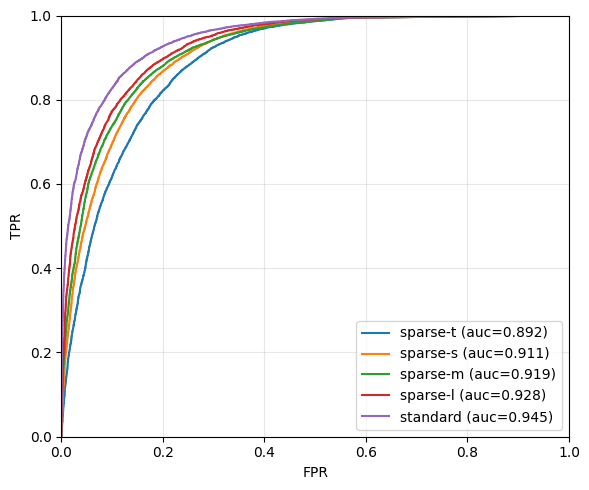

In [10]:
def plot_roc(y_true, y_preds, labels):
    plt.figure(figsize=(6,5))
    for y_pred, name in zip(y_preds, labels):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        a = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1.5, label=f"{name} (auc={a:.3f})")

    #plt.xscale('log')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_roc(y_true=y_test,  
         y_preds=[y_pred_sparse_t, y_pred_sparse_s, y_pred_sparse_m, y_pred_sparse_l, y_pred_full],
         labels=["sparse-t", "sparse-s", "sparse-m", "sparse-l", "standard"])

1/1 [==============================] - 0s 122ms/step


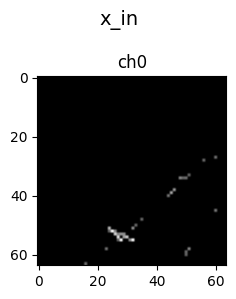

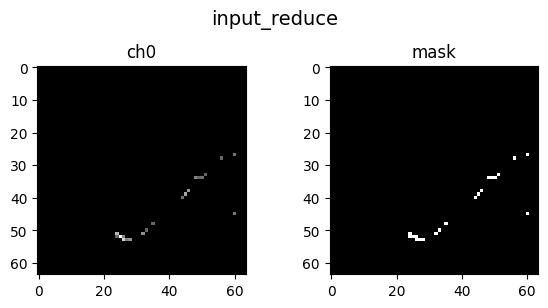

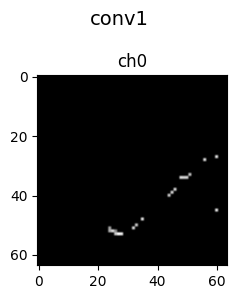

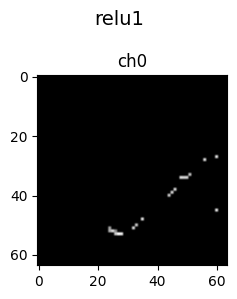

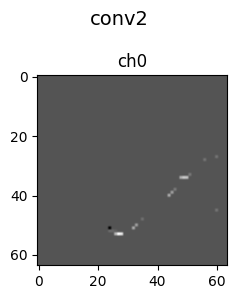

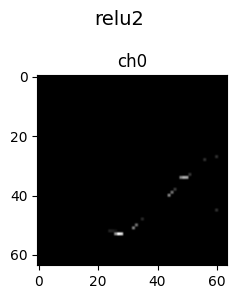

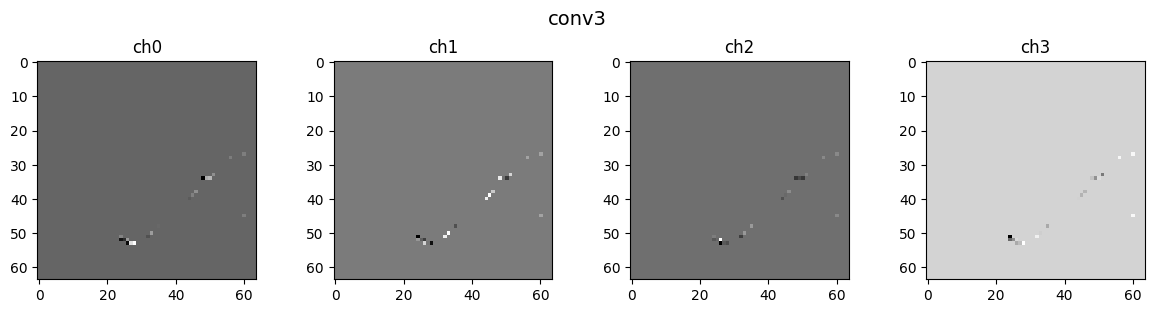

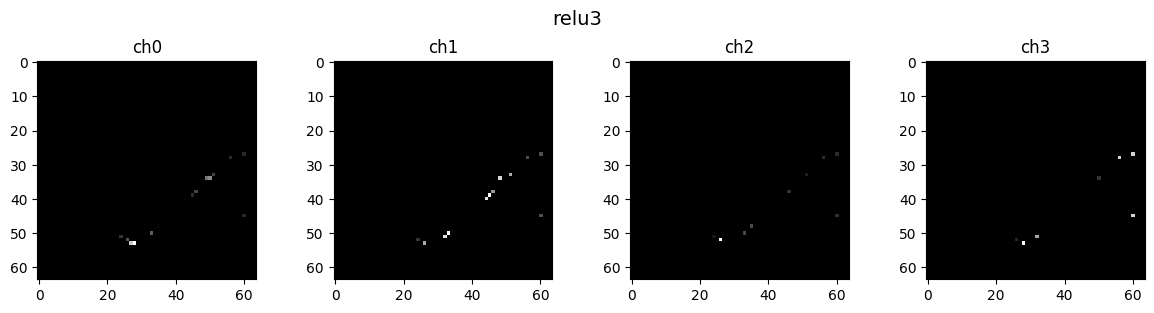

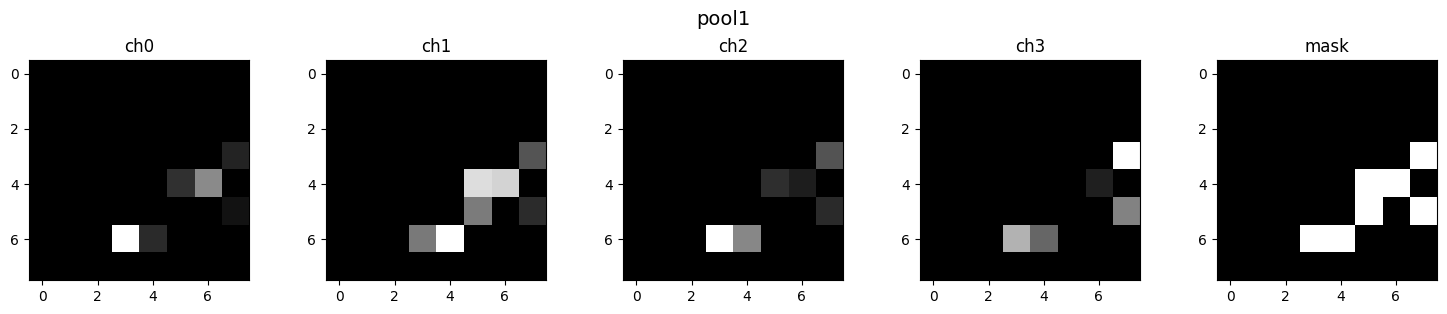

In [11]:
layer_names = [
    'x_in', 'input_reduce',
    'conv1', 'relu1', #'pool1',
    'conv2', 'relu2', #'pool2',
    'conv3', 'relu3', 'pool1',
]

plot_tensors = []
plot_names = []
for name in layer_names:
    layer = cnn_sparse_l.get_layer(name)
    output = layer.output
    if isinstance(output, (list, tuple)):
        plot_tensors.append(output[0])
        plot_names.append(f'{name} (x_reduced)')
        plot_tensors.append(output[1])
        plot_names.append(f'{name} (x_mask)')
    else:
        plot_tensors.append(output)
        plot_names.append(name)

model_cnnpart = models.Model(inputs=cnn_sparse_l.input, outputs=plot_tensors)
layers_pred = model_cnnpart.predict(x_test[31:32])

i = 0
while i < len(plot_names):
    name = plot_names[i]

    if "(x_reduced)" in name and i+1 < len(plot_names) and "(x_mask)" in plot_names[i+1]:
        out_r = layers_pred[i] # (1, h, w, c)
        out_m = layers_pred[i+1] # (1, h, w, 1)

        arr_r = out_r[0] # (h, w, c)
        arr_m = out_m[0,...,0] # (h, w)
        h, w, c = arr_r.shape

        fig, axes = plt.subplots(1, c+1, figsize=((c+1)*3, 3))
        fig.suptitle(name.replace(" (x_reduced)", ""), fontsize=14)

        for ch in range(c):
            ax = axes[ch]
            ax.imshow(arr_r[..., ch], cmap='gray')
            ax.set_title(f"ch{ch}")

        axm = axes[c]
        axm.imshow(arr_m, cmap='gray')
        axm.set_title("mask")

        plt.tight_layout()
        plt.show()

        i += 2
        continue

    out = layers_pred[i]
    arr = out[0]

    if arr.ndim == 2:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        fig.suptitle(name, fontsize=14)
        ax.imshow(arr, cmap='gray')
        ax.set_title("ch0")
        plt.tight_layout()
        plt.show()

    elif arr.ndim == 3:
        h, w, c = arr.shape
        fig, axes = plt.subplots(1, c, figsize=(c*3, 3))
        fig.suptitle(name, fontsize=14)
        for ch in range(c):
            ax = axes[ch] if c>1 else axes
            ax.imshow(arr[..., ch], cmap='gray')
            ax.set_title(f"ch{ch}")
        plt.tight_layout()
        plt.show()

    i += 1

In [ ]:
cnn_full.save_weights('weights/neutrino_full-8b.h5')
cnn_sparse_t.save_weights('weights/neutrino_sparse_t-8b.h5')
cnn_sparse_s.save_weights('weights/neutrino_sparse_s-8b.h5')
cnn_sparse_m.save_weights('weights/neutrino_sparse_m-8b.h5')
cnn_sparse_l.save_weights('weights/neutrino_sparse_l-8b.h5')

In [8]:
cnn_full = build_cnn(is_sparse=False)
cnn_sparse_t = build_cnn(is_sparse=True, n_max_pixels=8)
cnn_sparse_s = build_cnn(is_sparse=True, n_max_pixels=12)
cnn_sparse_m = build_cnn(is_sparse=True, n_max_pixels=16)
cnn_sparse_l = build_cnn(is_sparse=True, n_max_pixels=20)

cnn_full.load_weights('weights/neutrino_full-16b.h5')
cnn_sparse_t.load_weights('weights/neutrino_sparse_t-16b.h5')
cnn_sparse_s.load_weights('weights/neutrino_sparse_s-16b.h5')
cnn_sparse_m.load_weights('weights/neutrino_sparse_m-16b.h5')
cnn_sparse_l.load_weights('weights/neutrino_sparse_l-16b.h5')

## hls

In [ ]:
def build_cnn_sparse_forhls(cnn_sparse):
    x_in = keras.Input(shape=cnn_sparse.input_shape[1:], name="x_in")
    x = x_in
    for layer in cnn_sparse.layers:
        if isinstance(layer, keras.layers.InputLayer):
            continue
        if isinstance(layer, InputReduce):
            continue
        if layer.name.startswith("mask_pool"):
            continue

        if isinstance(layer, QConv2DSparse):
            cfg = layer.conv.get_config()
            cfg["use_bias"] = True
            cfg["name"] = layer.name
            cfg["bias_quantizer"] = layer._bias_quant_cfg

            conv_full = QConv2D.from_config(cfg)
            x = conv_full(x)

            kernel_w = layer.conv.get_weights()[0]
            bias_w = keras.backend.get_value(layer.bias)
            conv_full.set_weights([kernel_w, bias_w])
        elif isinstance(layer, AveragePooling2DSparse):
            x = layer.avg_pool(x)
        else:
            x = layer(x)

    return keras.Model(x_in, x, name='cnn_sparse_forhls')

cnn_sparse_t_forhls = build_cnn_sparse_forhls(cnn_sparse_t)
cnn_sparse_s_forhls = build_cnn_sparse_forhls(cnn_sparse_s)
cnn_sparse_m_forhls = build_cnn_sparse_forhls(cnn_sparse_m)
cnn_sparse_l_forhls = build_cnn_sparse_forhls(cnn_sparse_l)
cnn_sparse_s_forhls.summary()

In [ ]:
import hls4ml
def write_sparse_hls(cnn_sparse_forhls, name):
    config = hls4ml.utils.config_from_keras_model(cnn_sparse_forhls, granularity='name', backend='Vitis')
    #config['LayerName']['x_in']['Precision'] = 'ap_ufixed<8,1>'
    #config

    cnn_sparse_hls = hls4ml.converters.convert_from_keras_model(
        cnn_sparse_forhls,
        hls_config=config,
        project_name='myhls',
        backend='Vitis',
        output_dir=f'hls_proj/neutrino/model-16b/{name}',
        part='xcu250-figd2104-2L-e',
        io_type='io_parallel',
    )

    #cnn_sparse_hls.compile()
    cnn_sparse_hls.write()

write_sparse_hls(cnn_sparse_t_forhls, 'hls_sparse_t')
write_sparse_hls(cnn_sparse_s_forhls, 'hls_sparse_s')
write_sparse_hls(cnn_sparse_m_forhls, 'hls_sparse_m')
write_sparse_hls(cnn_sparse_l_forhls, 'hls_sparse_l')

In [ ]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(cnn_full, granularity='name', backend='Vivado')
#config['LayerName']['x_in']['Precision'] = 'ap_ufixed<8,1>'
#config['LayerName']['conv1']['ParallelizationFactor'] = 200
#config['LayerName']['conv2']['ParallelizationFactor'] = 50
#config

cnn_full_hls = hls4ml.converters.convert_from_keras_model(
    cnn_full,
    hls_config=config,
    project_name='myhls',
    backend='Vivado',
    output_dir='hls_proj/neutrino/model-16b/hls_full',
    part='xcu250-figd2104-2L-e',
    io_type='io_stream',
)

#cnn_full_hls.compile()
cnn_full_hls.write()

## testbench

In [ ]:
n_tb = 100
x_tb = x_test[:n_tb]
y_tb_t = y_pred_sparse_t[:n_tb]
y_tb_s = y_pred_sparse_s[:n_tb]
y_tb_m = y_pred_sparse_m[:n_tb]
y_tb_l = y_pred_sparse_l[:n_tb]
y_tb_full = y_pred_full[:n_tb]

bit = "16b"

# inputs
with open("hls_proj/neutrino/model-"+bit+"/hls_sparse_t/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/neutrino/model-"+bit+"/hls_sparse_s/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/neutrino/model-"+bit+"/hls_sparse_m/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/neutrino/model-"+bit+"/hls_sparse_l/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/neutrino/model-"+bit+"/hls_full/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

# predictions
with open("hls_proj/neutrino/model-"+bit+"/hls_sparse_t/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_t:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/neutrino/model-"+bit+"/hls_sparse_s/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_s:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/neutrino/model-"+bit+"/hls_sparse_m/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_m:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/neutrino/model-"+bit+"/hls_sparse_l/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_l:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/neutrino/model-"+bit+"/hls_full/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_full:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")